## Minesweeper RL

In this notebook I'll try different ways to solve the Game of MineSweeper.
1. I will try to solve the fixed grid of Minesweeper.
    * QLearning
    * SequenceAgent <- Because in the determined field the agent actually need to understand the states ony a sequence of actions that maximizes the reward.
    * DQN (But only with the click action and not with the flagging action)
        - DQNAgentTorch (Single-network CNN Minesweeper Agent)
        - DuelingQNetwork (Dueling CNN Double-Network DQN Agent)
2. Depending on the duability of the first part i'll explore the dynamic case of actually solving the normal minesweeper game.

In [38]:
import random
from collections import deque
import numpy as np
from gym import Env
from gym.spaces import MultiDiscrete, Box
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

I added the option to set the enviroment to deterministic, meaning the mines are at the same place for every reset of the enviroment. The second thing is to secure the first click, most of Minesweeper games have this. The first click should reveal parts of the beard by flooding tiles. This is done by securing that the first clicked has no surrounding bombs.

In [39]:
import numpy as np
from collections import deque
from gym import Env
from gym.spaces import MultiDiscrete, Box

# Tile states and actions encoded:
#   -1 = hidden, -2 = flagged, 0-8 = revealed counts, -3 = revealed mine
STATE_HIDDEN = -1
STATE_FLAGGED = -2
STATE_MINE = -3

ACTION_CLICK = 0
ACTION_FLAG = 1

class MinesweeperEnv(Env):
    """
    Gym environment for Minesweeper with click+flag actions.
    Observation: grid of ints (-1 hidden, -2 flagged, 0-8 counts).
    Action: (action_type, x, y).
    """
    def __init__(self, size_x=9, size_y=9, mine_prob=0.15,
                 deterministic=True, secure_first_click=False):
        super().__init__()
        self.size_x = size_x
        self.size_y = size_y
        self.mine_prob = mine_prob
        self.secure_first_click = secure_first_click
        self.deterministic = deterministic
        self.max_steps = size_x * size_y
        self.rng = None
        self.done = False

        self.action_space = MultiDiscrete([2, size_x, size_y])
        self.observation_space = Box(low=-3, high=8,
                                     shape=(size_x, size_y), dtype=np.int8)
        self.reset()

    def reset(self):
        """Reset game state."""
        self.done = False
        self.first_click = True
        self.steps = 0
        self.clicked_count = 0
        self.flag_count = 0
        self.correct_flag_count = 0
        self.mines = 0
        self.state = np.full((self.size_x, self.size_y), STATE_HIDDEN, dtype=np.int8)
        self.is_mine = np.zeros((self.size_x, self.size_y), dtype=bool)
        self.adjacent = np.zeros((self.size_x, self.size_y), dtype=np.int8)
        return self._obs()

    def step(self, action):
        """Apply action, increment step, enforce limit, return (obs, reward, done, info)."""
        action_type, x, y = map(int, action)
        reward = 0.0

        # Increment step and check limit
        self.steps += 1

        # First-click: only clicks place mines; flags are penalized but count as a step
        if self.first_click:
            if action_type == ACTION_CLICK:
                self._place_mines(x, y)
            else:
                # flag on first move: simple penalty
                return self._obs(), -1.0, self.done, {}

        # Handle click
        if action_type == ACTION_CLICK:
            # ignore clicks on non-hidden
            if self.state[x, y] != STATE_HIDDEN:
                return self._obs(), -1.0, self.done, {}
            # mine -> lose
            if self.is_mine[x, y]:
                self.state[x, y] = STATE_MINE
                return self._obs(), -1, True, {}
            # check blind guess
            neighbor_vals = []
            for dx in (-1, 0, 1):
                for dy in (-1, 0, 1):
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.size_x and 0 <= ny < self.size_y:
                        neighbor_vals.append(self.state[nx, ny])
            is_guess = all(val == STATE_HIDDEN for val in neighbor_vals)
            # reveal
            self._flood_fill(x, y)
            reward = -1.0 if is_guess and not self.first_click else 1.0
            self.first_click = False

        # Handle flag/unflag
        else:
            prev = self.state[x, y]
            if prev == STATE_HIDDEN:
                self.state[x, y] = STATE_FLAGGED
                self.flag_count += 1
                if self.is_mine[x, y]:
                    self.correct_flag_count += 1
                    reward = 0.5
                else:
                    reward = -0.5
            elif prev == STATE_FLAGGED:
                self.state[x, y] = STATE_HIDDEN
                self.flag_count -= 1
                if self.is_mine[x, y]:
                    self.correct_flag_count -= 1
                    reward = -0.3
                else:
                    reward = +0.3
            else:
                # flag on revealed cell: no effect
                reward = -1

        # Check win
        total_safe = self.size_x * self.size_y - self.mines
        if not self.done and self.clicked_count >= total_safe:
            reward += 1.0
            self.done = True

        if self.steps >= self.max_steps:
            self.done = True

        return self._obs(), reward, self.done, {}

    def _place_mines(self, safe_x, safe_y):
        """Place mines after first click, protecting safe cell and optionally neighbors."""
        self.rng = np.random.default_rng(0 if self.deterministic else None)
        protected = set()
        if self.secure_first_click:
            for dx in (-1, 0, 1):
                for dy in (-1, 0, 1):
                    nx, ny = safe_x + dx, safe_y + dy
                    if 0 <= nx < self.size_x and 0 <= ny < self.size_y:
                        protected.add((nx, ny))
        self.is_mine.fill(False)
        self.adjacent.fill(0)
        self.mines = 0
        for i in range(self.size_x):
            for j in range(self.size_y):
                if (i, j) in protected:
                    continue
                if self.rng.random() < self.mine_prob:
                    self.is_mine[i, j] = True
                    self.mines += 1
        for i in range(self.size_x):
            for j in range(self.size_y):
                if self.is_mine[i, j]:
                    continue
                count = 0
                for nx in range(max(0, i-1), min(self.size_x, i+2)):
                    for ny in range(max(0, j-1), min(self.size_y, j+2)):
                        if (nx, ny) != (i, j) and self.is_mine[nx, ny]:
                            count += 1
                self.adjacent[i, j] = count

    def _flood_fill(self, sx, sy):
        """Reveal zero clusters and border cells via BFS."""
        queue = deque([(sx, sy)])
        while queue:
            i, j = queue.popleft()
            if self.state[i, j] != STATE_HIDDEN:
                continue
            self.state[i, j] = self.adjacent[i, j]
            self.clicked_count += 1
            self.steps += 1
            if self.adjacent[i, j] == 0:
                for di in (-1, 0, 1):
                    for dj in (-1, 0, 1):
                        ni, nj = i + di, j + dj
                        if 0 <= ni < self.size_x and 0 <= nj < self.size_y:
                            queue.append((ni, nj))

    def _obs(self):
        """Copy of current state grid (for observation)."""
        return self.state.copy()

    def _reveal(self):
        """Copy of mine layout (for debugging)."""
        return self.is_mine.copy()


### Proving that the mines are deterministic

In [40]:
env = MinesweeperEnv(size_x=9, size_y=9, mine_prob=0.15, deterministic=True, secure_first_click=False)
# Test the environment
obs = env.reset()
print(obs)
obs, reward, done, info = env.step([0, 3, 2])  # Click on (2, 2)
mines1 = env._reveal()
print(env._reveal())
print(obs)
obs = env.reset()
obs, reward, done, info = env.step([0, 1, 2])  # Click on (2, 2)
mines2 = env._reveal()
print(env._reveal())
print(obs)

# Check if the two mines are the same
if np.array_equal(mines1, mines2):
    print("The two mines are the same.")
else:
    print("The two mines are different.")

[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]]
[[False False  True  True False False False False False]
 [False False  True False  True False False False False]
 [False False  True  True False False False False False]
 [False False False False False  True False False False]
 [False False False False False False False False False]
 [False False False  True False False False False  True]
 [False False False False False  True False False  True]
 [False False False False False False  True False False]
 [False False False False False False False False False]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1  2 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 

# Deterministic QLearning with no secure first pick
Just learning the mine placement and get the highest amount of rewards

In [41]:
# Reverse mapping from action to index for the action space

def index_to_action(idx, size_x, size_y):
    # idx in [0 .. 2*size_x*size_y-1]
    # action_type = 0 or 1
    n_cells = size_x * size_y
    action_type = idx // n_cells
    rem = idx % n_cells
    x = rem // size_y
    y = rem % size_y
    return (action_type, x, y)

In [42]:
class QLearningAgent:
    def __init__(self, n_actions, alpha, gamma, epsilon):
        self.n_actions = n_actions
        self.lr       = alpha
        self.gamma    = gamma
        self.epsilon  = epsilon
        # dict mapping state_key -> Q-vector of size n_actions
        self.Q = defaultdict(lambda: np.zeros(self.n_actions))

    def state_key(self, state: np.ndarray):
        # flatten to a hashable key
        return tuple(state.flatten().tolist())

    def act(self, state: np.ndarray):
        key = self.state_key(state)
        if random.random() < self.epsilon:
            return random.randrange(self.n_actions)
        # tie-break among max args
        qvals = self.Q[key]
        best = np.flatnonzero(qvals == qvals.max())
        return random.choice(best)

    def update(self, state, action, reward, next_state):
        k  = self.state_key(state)
        k2 = self.state_key(next_state)
        target = reward + self.gamma * np.max(self.Q[k2])
        self.Q[k][action] += self.lr * (target - self.Q[k][action])

    def reset(self):
        self.Q.clear()

### Training the QLearning Agent on deterministic a 10x10 grid with 0.2 mine probability

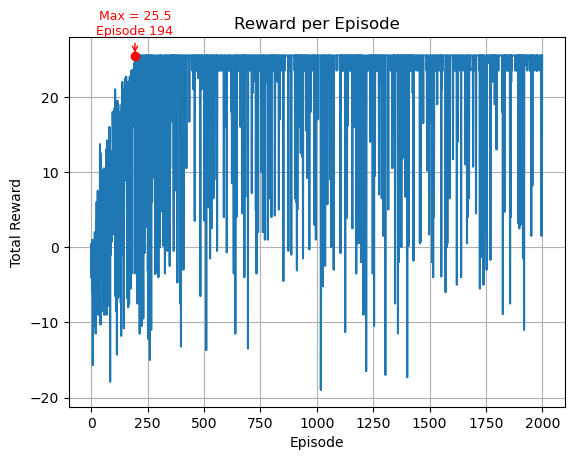

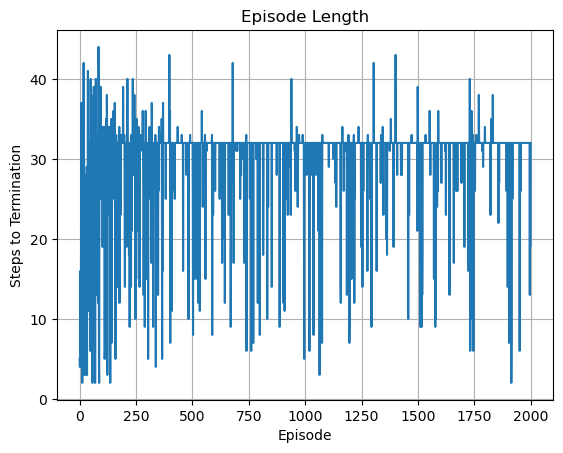

In [43]:
# --- hyperparams ---
N_EPISODES = 2000
ALPHA      = 0.01
GAMMA      = 0.9
EPSILON    = 0.1

# create env
env = MinesweeperEnv(size_x=9, size_y=9, mine_prob=0.15, deterministic=True, secure_first_click=False)
size_x, size_y = env.size_x, env.size_y
n_actions = 2 * size_x * size_y

agent = QLearningAgent(n_actions, alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON)

# metrics
episode_rewards = []
episode_lengths = []
mines = []

for ep in range(N_EPISODES):
    state = env.reset()
    total_r = 0.0
    done = False
    t = 0
    while not done:
        a_idx = agent.act(state)
        action = index_to_action(a_idx, size_x, size_y)
        next_state, reward, done, _ = env.step(action)

        agent.update(state, a_idx, reward, next_state)

        state = next_state
        total_r += reward
        t += 1
    
    mines.append(env._reveal())

    episode_rewards.append(total_r)
    episode_lengths.append(t+1)
    # optional: decay epsilon over time
    agent.epsilon = max(0.01, agent.epsilon * 0.995)

idx_max = np.argmax(episode_rewards)
max_val = episode_rewards[idx_max]

fig, ax = plt.subplots()
ax.plot(episode_rewards, label="Reward")
ax.scatter(idx_max, max_val, color="red", zorder=5)  # roten Punkt beim Maximum
ax.annotate(f"Max = {max_val:.1f}\nEpisode {idx_max}",
            xy=(idx_max, max_val),
            xytext=(0, 15),
            textcoords="offset points",
            ha="center",
            color="red",
            fontsize=9,
            arrowprops=dict(arrowstyle="->", color="red"))

ax.set_xlabel("Episode")
ax.set_ylabel("Total Reward")
ax.set_title("Reward per Episode")
ax.grid(True)

# Stelle sicher, dass die y-Achse bis zum Maximum reicht + kleinen Rand
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, max_val + (ymax - ymin)*0.05)


# Episode Length
fig, ax = plt.subplots()
ax.plot(episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Steps to Termination")
ax.set_title("Episode Length")
ax.grid(True)


plt.show()

In [44]:
# visualize_q_learning.py

import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

def index_to_action(idx: int, size_x: int, size_y: int):
    """
    Convert flat index [0 .. 2*size_x*size_y) into
    (action_type, x, y) tuple for the env's MultiDiscrete space.
    """
    n_cells = size_x * size_y
    action_type = idx // n_cells
    rem = idx % n_cells
    x = rem // size_y
    y = rem % size_y
    return (action_type, x, y)

def visualize_q(agent: QLearningAgent,
                env: MinesweeperEnv,
                out_path: str = "q_board.gif",
                fps: int = 2):
    # force purely greedy policy
    agent.epsilon = 0.0

    frames, actions = [], []
    state = env.reset()
    frames.append(env.state.copy())
    done = False

    while not done:
        a_idx = agent.act(state)
        actions.append(a_idx)

        action = index_to_action(a_idx, env.size_x, env.size_y)
        state, _, done, _ = env.step(action)
        frames.append(env.state.copy())

    H, W = env.size_x, env.size_y
    fig, ax = plt.subplots(figsize=(5,5), dpi=300)
    ax.set_xticks(np.arange(W+1)-0.5)
    ax.set_yticks(np.arange(H+1)-0.5)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.grid(color="black")
    ax.set_title("Q‐Learning agent solving Minesweeper")

    # text objects for cell contents
    txt = [[ax.text(j, i, "", ha="center", va="center", fontsize=12)
            for j in range(W)] for i in range(H)]
    # red square marker for the click
    click_marker, = ax.plot([], [], "s", ms=40, mfc="none", mec="red", lw=2)

    def update(k):
        board = frames[k]
        for i in range(H):
            for j in range(W):
                v = int(board[i,j])
                if v == STATE_HIDDEN:
                    s = "#"
                elif v == STATE_FLAGGED:
                    s = "⚑"
                elif v == STATE_MINE:
                    s = "M"
                else:
                    s = str(v)
                txt[i][j].set_text(s)

        if k > 0:
            a = actions[k-1]
            x, y = index_to_action(a, H, W)[1:]
            click_marker.set_data([y], [x])
        else:
            click_marker.set_data([], [])

        ax.set_xlabel(f"Step {k}")
        return [click_marker] + [t for row in txt for t in row]

    ani = animation.FuncAnimation(
        fig, update, frames=len(frames),
        interval=1000, blit=True
    )
    ani.save(out_path, writer="pillow", fps=1)
    print(f"Saved GIF → {out_path}")
    plt.close(fig)

# 3) recreate env
env = MinesweeperEnv(
    size_x=9, size_y=9,
    mine_prob=0.15,
    deterministic=True,
    secure_first_click=False
)

# 4) visualize
visualize_q(agent, env, out_path="ql_board.gif", fps=2)


Saved GIF → ql_board.gif


In [33]:
mine_board = np.array(mines)

def all_elements_equal(arr):
    first = arr[0]
    for i in range(1, len(arr)):
        if not np.array_equal(arr[i], first):
            print(f"Difference found at index {i}:")
            print("First board:\n", first)
            print(f"Different board at step {i}:\n", arr[i])
            return False
    return True

all_equal = all_elements_equal(mine_board)

if all_equal:
    print("All elements in the mine board are equal.")
else:
    print("Not all elements in the mine board are equal.")

Difference found at index 1:
First board:
 [[False False False  True False False False False False]
 [False False False False False  True False False  True]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False  True False False  True]
 [False False False False  True False False False False]
 [False False False False False False  True  True False]
 [False False False False False False  True  True False]]
Different board at step 1:
 [[ True False False False  True False False False False]
 [False False False False False False  True False  True]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False  True False False False False False False False]
 [False False False False False False False False False]
 [False False  True False False False False  True False]
 [ True  True Fa

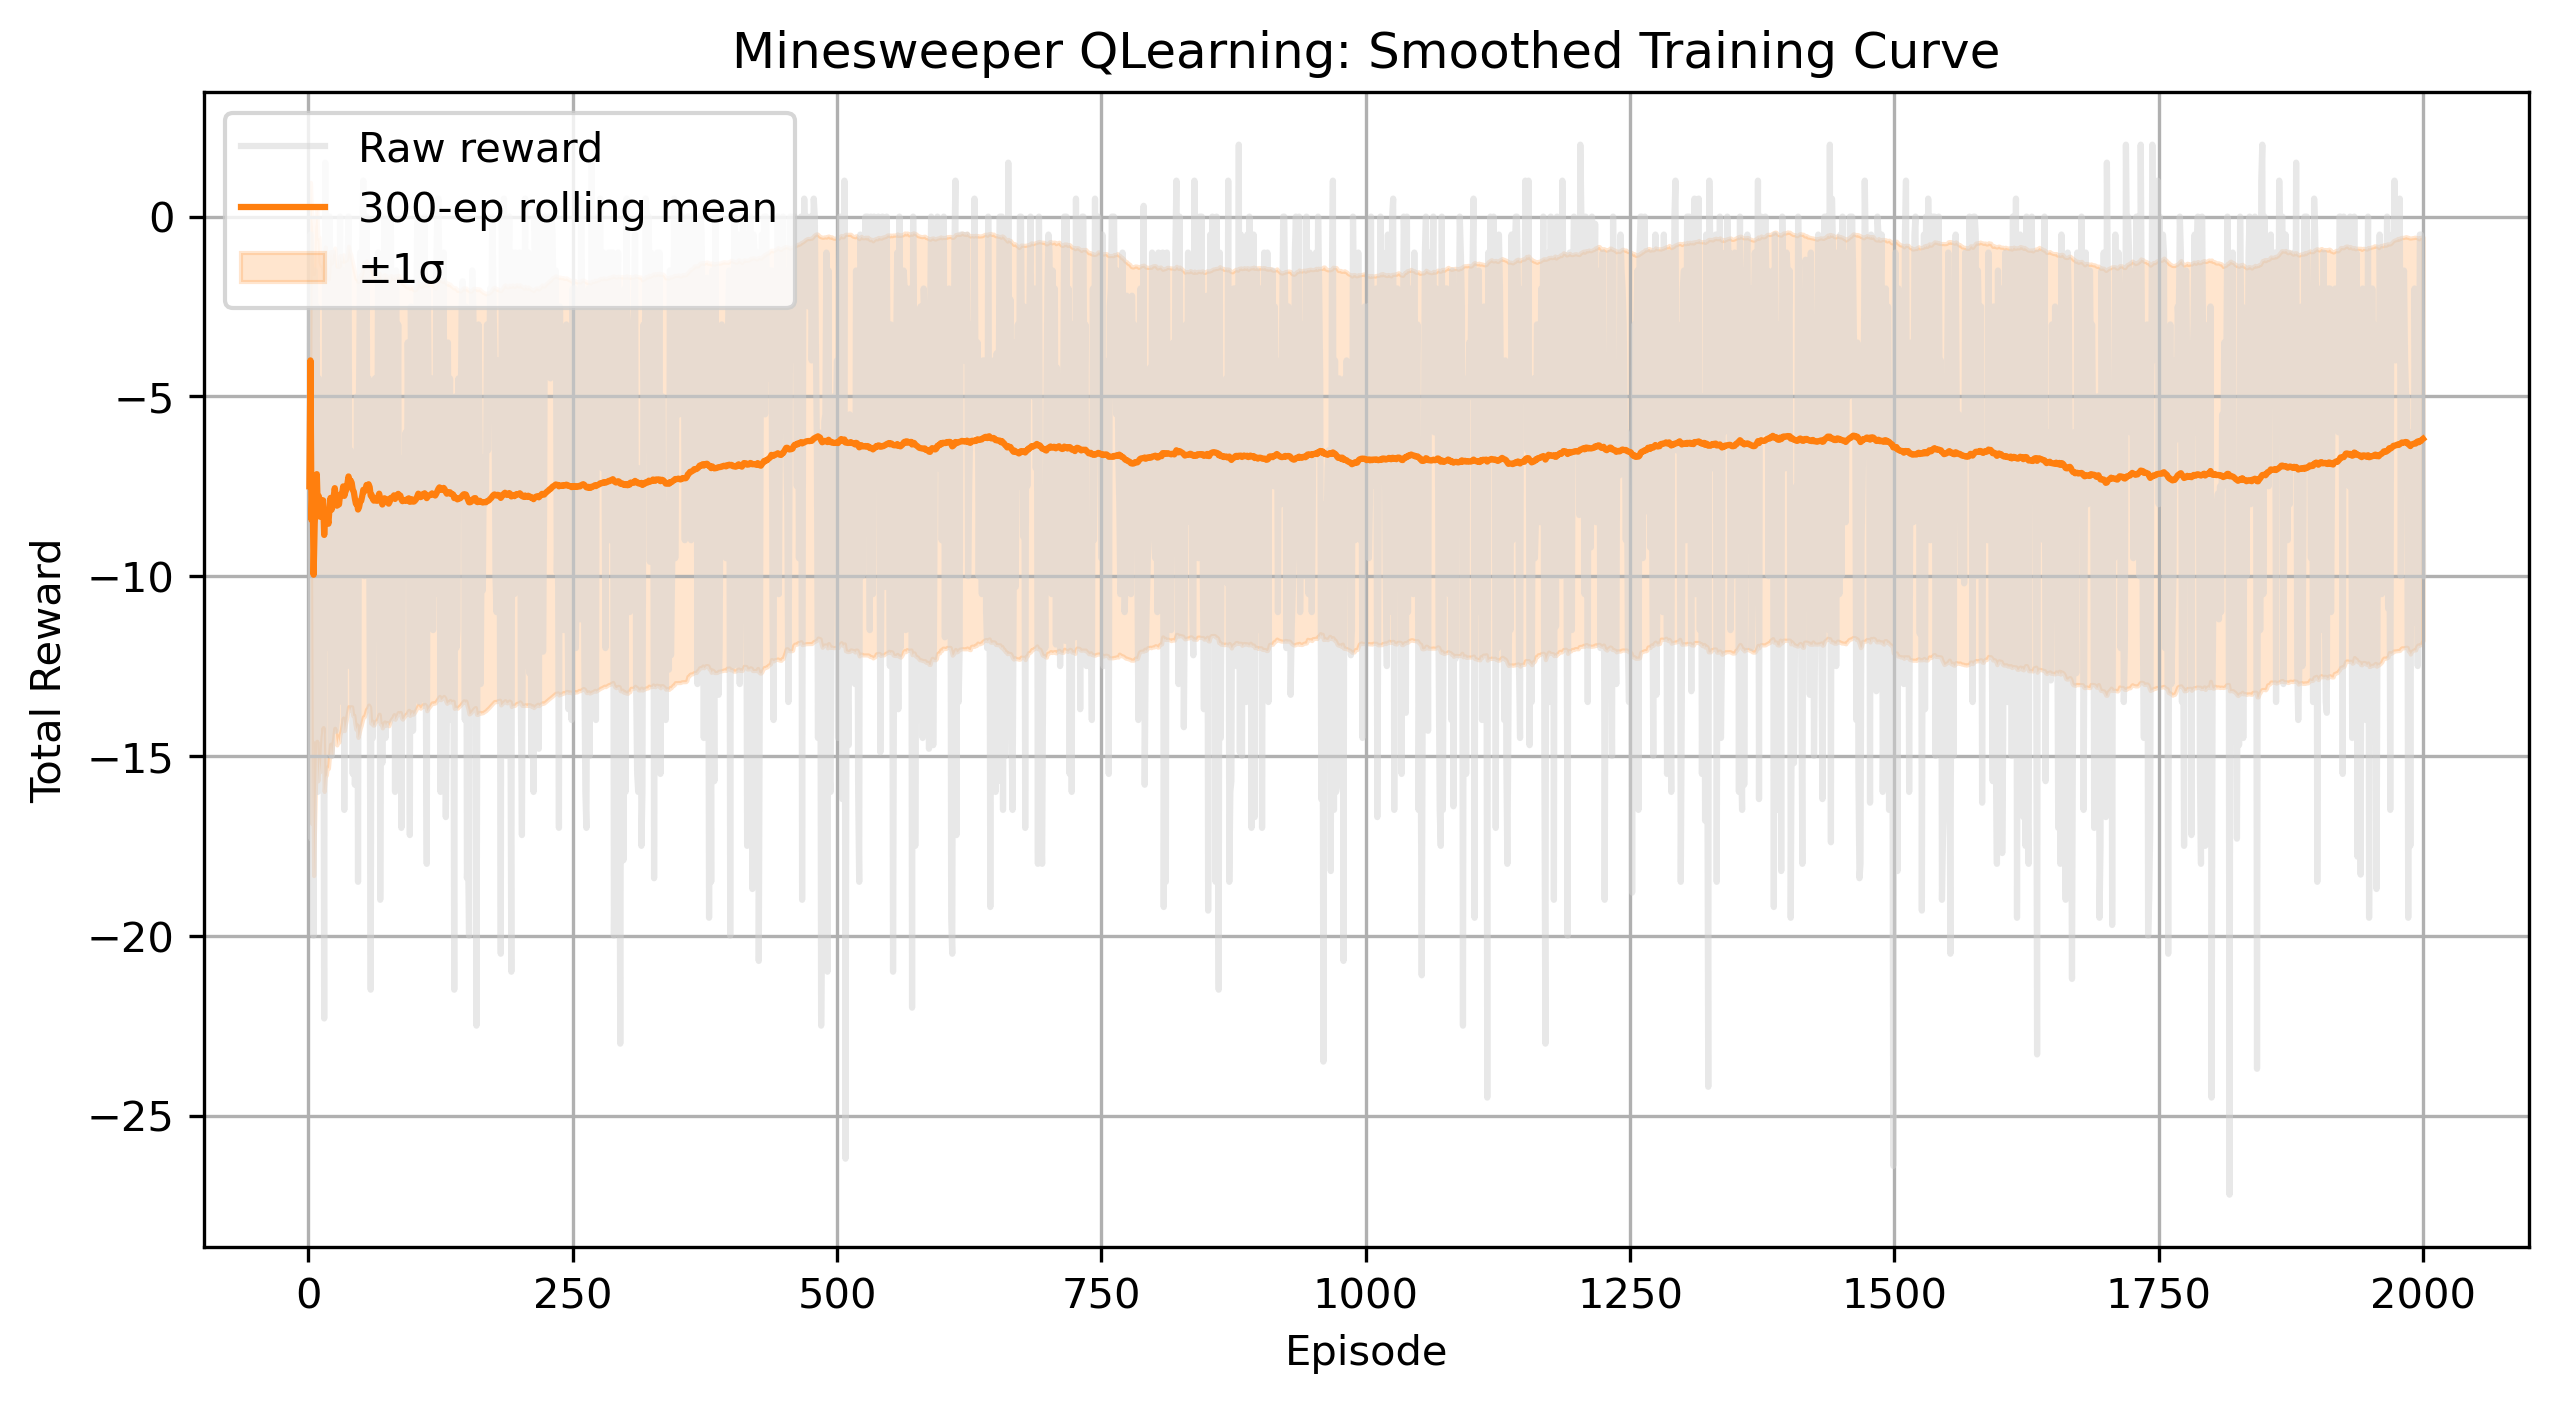

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# turn your list into a DataFrame
df = pd.DataFrame({
    'episode': range(1, len(episode_rewards)+1),
    'reward': episode_rewards
})

# compute rolling statistics
window = 300
df['roll_mean'] = df['reward'].rolling(window, min_periods=1).mean()
df['roll_std']  = df['reward'].rolling(window, min_periods=1).std().fillna(0)

# now plot
plt.figure(figsize=(10,5),dpi=300)
# raw rewards as faint background
plt.plot(df['episode'], df['reward'], color='lightgray', alpha=0.5, label='Raw reward')
# rolling mean
plt.plot(df['episode'], df['roll_mean'], color='C1', label=f'{window}-ep rolling mean')
# ±1σ shading
plt.fill_between(df['episode'],
                 df['roll_mean'] - df['roll_std'],
                 df['roll_mean'] + df['roll_std'],
                 color='C1', alpha=0.2, label='±1σ')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Minesweeper QLearning: Smoothed Training Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### This helps to visualize the step sequence of the trained model

In [20]:
# Helper to pretty-print the board
def print_board(obs):
    charmap = {-1: '#', -2: 'F'}
    for row in obs:
        print(' '.join(charmap.get(int(c), str(int(c))) for c in row))
    print()

# Greedy policy (no exploration)
agent.epsilon = 0.0
state = env.reset()
print("Initial board:")
print_board(state)

done = False
step = 0
tot_reward = 0.0
while not done and step < env.max_steps:
    # pick the greedy action
    a_idx = agent.act(state)
    action = index_to_action(a_idx, env.size_x, env.size_y)
    print(f"Step {step}: action={action}")

    next_state, reward, done, _ = env.step(action)
    print(f" Reward: {reward:.2f}")
    print_board(next_state)

    state = next_state
    step += 1
    tot_reward += reward

if done:
    print("Episode finished in", step, "steps.")
    print("total reward:", tot_reward)
else:
    print("Reached max steps without finishing.")


Initial board:
# # # # # # # # #
# # # # # # # # #
# # # # # # # # #
# # # # # # # # #
# # # # # # # # #
# # # # # # # # #
# # # # # # # # #
# # # # # # # # #
# # # # # # # # #

Step 0: action=(0, 7, 0)
 Reward: 1.00
0 2 # # # # # # #
0 3 # # # # # # #
0 2 # # # # # # #
0 1 2 # # # # # #
0 0 1 # # # # # #
0 0 1 # # # # # #
0 0 1 1 2 # # # #
0 0 0 0 1 2 # # #
0 0 0 0 0 1 # # #

Step 1: action=(0, 6, 6)
 Reward: 1.00
0 2 # # # # # # #
0 3 # # # # # # #
0 2 # # # # # # #
0 1 2 # # # # # #
0 0 1 # # # # # #
0 0 1 # # # # # #
0 0 1 1 2 # 2 # #
0 0 0 0 1 2 # # #
0 0 0 0 0 1 # # #

Step 2: action=(1, 6, 8)
 Reward: 0.50
0 2 # # # # # # #
0 3 # # # # # # #
0 2 # # # # # # #
0 1 2 # # # # # #
0 0 1 # # # # # #
0 0 1 # # # # # #
0 0 1 1 2 # 2 # F
0 0 0 0 1 2 # # #
0 0 0 0 0 1 # # #

Step 3: action=(0, 4, 3)
 Reward: 1.00
0 2 # # # # # # #
0 3 # # # # # # #
0 2 # # # # # # #
0 1 2 # # # # # #
0 0 1 1 # # # # #
0 0 1 # # # # # #
0 0 1 1 2 # 2 # F
0 0 0 0 1 2 # # #
0 0 0 0 0 1 # # #

Step 4: action

# Idea with action mask to not have to give negativ rewards except mine.
### Action mask should be only undiscovered and tiles that have at least one adjacent clicked tile.

In [46]:
import numpy as np
from collections import deque
from gym import Env
from gym.spaces import MultiDiscrete, Box

# -------------------------------------------------------------------------
# Constants
# -------------------------------------------------------------------------
STATE_HIDDEN = -1
STATE_FLAGGED = -2
STATE_MINE = -3

ACTION_CLICK = 0
ACTION_FLAG = 1


class MinesweeperEnv(Env):
    """
    Gym environment for Minesweeper with click + flag actions **and** legal‑action
    masks that forbid blind guesses.

    ``reset`` and ``step`` now return::

        obs, reward, done, info

    where **info** contains two masks:

    - ``action_mask_click`` : np.int8 [size_x, size_y]
    - ``action_mask_flag``  : np.int8 [size_x, size_y]

    A value **1** means the (x,y) coordinate is a *legal* target for the
    corresponding action, **0** means the action is disallowed.
    """

    def __init__(self, size_x: int = 10, size_y: int = 10, mine_prob: float = 0.1,
                 deterministic: bool = True, secure_first_click: bool = False):
        super().__init__()
        self.size_x = size_x
        self.size_y = size_y
        self.mine_prob = mine_prob
        self.secure_first_click = secure_first_click
        self.deterministic = deterministic
        self.max_steps = size_x * size_y

        # Gym spaces ------------------------------------------------------
        self.action_space = MultiDiscrete([2, size_x, size_y])
        self.observation_space = Box(low=-3, high=8,
                                     shape=(size_x, size_y), dtype=np.int8)

        # Runtime state placeholders --------------------------------------
        self.state = None            # visible board
        self.is_mine = None          # hidden mine layout
        self.adjacent = None         # adjacent‑mine counts
        self.action_mask_click = None
        self.action_mask_flag = None

        self.reset()

    # ---------------------------------------------------------------------
    # Public API
    # ---------------------------------------------------------------------
    def reset(self, *, seed=None, options=None):
        """Start a new episode and return (**obs**, **info**)."""
        super().reset(seed=seed)

        self.done = False
        self.first_click = True
        self.steps = 0
        self.clicked_count = 0
        self.flag_count = 0
        self.correct_flag_count = 0
        self.mines = 0

        self.state = np.full((self.size_x, self.size_y), STATE_HIDDEN, dtype=np.int8)
        self.is_mine = np.zeros((self.size_x, self.size_y), dtype=bool)
        self.adjacent = np.zeros((self.size_x, self.size_y), dtype=np.int8)

        # Masks: 1 = legal, 0 = illegal
        self.action_mask_click = np.zeros((self.size_x, self.size_y), dtype=np.int8)
        self.action_mask_flag  = np.zeros_like(self.action_mask_click)      # ✅ correct


        self._update_masks()
        return self._obs(), self._info()

    def step(self, action):
        """Apply *(action_type, x, y)* and return (**obs**, reward, done, info)."""
        if self.done:
            raise RuntimeError("step() called after episode has terminated")

        action_type, x, y = map(int, action)
        reward = 0.0

        # First click lazily places mines ---------------------------------
        if self.first_click and action_type == ACTION_CLICK:
            self._place_mines(x, y)

        # -----------------------------------------------------------------
        # CLICK action
        # -----------------------------------------------------------------
        if action_type == ACTION_CLICK:
            if self.state[x, y] != STATE_HIDDEN:
                reward = -1.0  # invalid click
            elif self.is_mine[x, y]:
                self.state[x, y] = STATE_MINE
                self.done = True
                reward = -3.0
            else:
                was_guess = not self._has_revealed_neighbor(x, y)
                self._flood_fill(x, y)
                reward = -1.0 if was_guess and not self.first_click else 1.0

        # -----------------------------------------------------------------
        # FLAG / unflag action
        # -----------------------------------------------------------------
        else:  # ACTION_FLAG
            cur = self.state[x, y]
            if cur == STATE_HIDDEN:
                # set flag
                self.state[x, y] = STATE_FLAGGED
                self.flag_count += 1
                reward = 0.5 if self.is_mine[x, y] else -0.5
                if self.is_mine[x, y]:
                    self.correct_flag_count += 1
            elif cur == STATE_FLAGGED:
                # remove flag
                self.state[x, y] = STATE_HIDDEN
                self.flag_count -= 1
                reward = -0.2 if self.is_mine[x, y] else 0.2
                if self.is_mine[x, y]:
                    self.correct_flag_count -= 1
            else:
                reward = -1.0  # flagging revealed tile => penalty

        # -----------------------------------------------------------------
        # Book‑keeping & termination checks
        # -----------------------------------------------------------------
        self.first_click = False
        self.steps += 1

        total_safe = self.size_x * self.size_y - self.mines
        if not self.done and self.clicked_count >= total_safe:
            self.done = True
            reward += 2.0

        if self.steps >= self.max_steps:
            self.done = True

        # Refresh legal action masks for next decision
        self._update_masks()
        return self._obs(), reward, self.done, self._info()

    # ---------------------------------------------------------------------
    # Action‑mask helpers
    # ---------------------------------------------------------------------
    def _has_revealed_neighbor(self, x: int, y: int) -> bool:
        """True if *(x,y)* touches at least one revealed (0‑8) tile."""
        for dx in (-1, 0, 1):
            for dy in (-1, 0, 1):
                if dx == 0 and dy == 0:
                    continue
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.size_x and 0 <= ny < self.size_y:
                    if 0 <= self.state[nx, ny] <= 8:
                        return True
        return False

    def _update_masks(self):
        """Recompute which (x,y) are legal for CLICK / FLAG actions."""
        self.action_mask_click.fill(0)
        self.action_mask_flag.fill(0)

        for i in range(self.size_x):
            for j in range(self.size_y):
                s = self.state[i, j]

                # CLICK mask ------------------------------------------------
                if s == STATE_HIDDEN:
                    if self.first_click or self._has_revealed_neighbor(i, j):
                        self.action_mask_click[i, j] = 1

                # FLAG mask -------------------------------------------------
                if s == STATE_FLAGGED:
                    # always allow deflagging
                    self.action_mask_flag[i, j] = 1
                elif s == STATE_HIDDEN and (self.first_click or self._has_revealed_neighbor(i, j)):
                    # allow flagging only if it isn't a blind guess
                    self.action_mask_flag[i, j] = 1
        if not self.action_mask_click.any() and not self.action_mask_flag.any() and not self.done:
        # no inference-safe move exists → allow blind clicks on hidden tiles
            self.action_mask_click[self.state == STATE_HIDDEN] = 1

    # ---------------------------------------------------------------------
    # Original helper functions (minimally cleaned up)
    # ---------------------------------------------------------------------
    def _place_mines(self, safe_x: int, safe_y: int):
        rng = np.random.default_rng(0 if self.deterministic else None)
        protected = {(safe_x, safe_y)} if not self.secure_first_click else {
            (safe_x + dx, safe_y + dy)
            for dx in (-1, 0, 1) for dy in (-1, 0, 1)
            if 0 <= safe_x + dx < self.size_x and 0 <= safe_y + dy < self.size_y
        }

        self.is_mine.fill(False)
        self.adjacent.fill(0)
        self.mines = 0

        for i in range(self.size_x):
            for j in range(self.size_y):
                if (i, j) in protected:
                    continue
                if rng.random() < self.mine_prob:
                    self.is_mine[i, j] = True
                    self.mines += 1

        for i in range(self.size_x):
            for j in range(self.size_y):
                if self.is_mine[i, j]:
                    continue
                cnt = 0
                for ni in range(max(0, i - 1), min(self.size_x, i + 2)):
                    for nj in range(max(0, j - 1), min(self.size_y, j + 2)):
                        if (ni, nj) != (i, j) and self.is_mine[ni, nj]:
                            cnt += 1
                self.adjacent[i, j] = cnt

    def _flood_fill(self, sx: int, sy: int):
        """Reveal 0‑clusters and their numbered border via BFS."""
        q = deque([(sx, sy)])
        while q:
            i, j = q.popleft()
            if self.state[i, j] != STATE_HIDDEN:
                continue
            self.state[i, j] = self.adjacent[i, j]
            self.clicked_count += 1

            if self.adjacent[i, j] == 0:
                for di in (-1, 0, 1):
                    for dj in (-1, 0, 1):
                        ni, nj = i + di, j + dj
                        if 0 <= ni < self.size_x and 0 <= nj < self.size_y:
                            q.append((ni, nj))

    # ---------------------------------------------------------------------
    # Utilities
    # ---------------------------------------------------------------------
    def _obs(self):
        return self.state.copy()

    def _info(self):
        return {
            "action_mask_click": self.action_mask_click.copy(),
            "action_mask_flag": self.action_mask_flag.copy(),
        }

    def _reveal(self):
        """Return full mine layout (for debugging / unit‑tests)."""
        return self.is_mine.copy()


# Optional helper: register with Gym so you can ``gym.make('Minesweeper-v0')``
try:
    import gym
    gym.register(id="Minesweeper-v0", entry_point=MinesweeperEnv)
except gym.error.Error:
    # already registered in this session
    pass


/Users/bastienjossen/anaconda3/envs/RL/lib/python3.11/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment Minesweeper-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


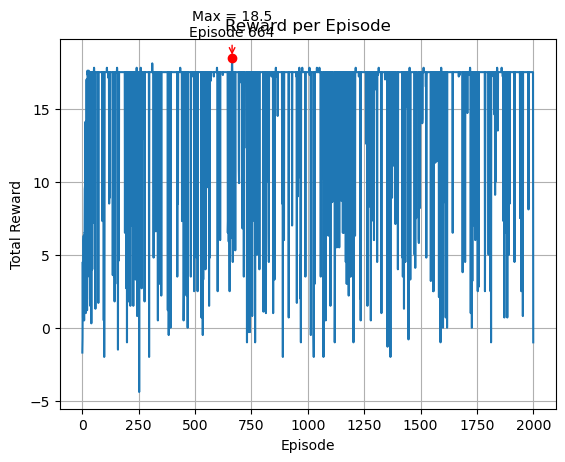

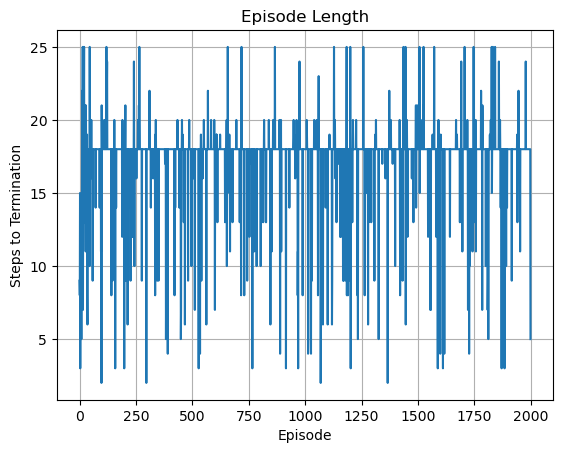

In [47]:
import random, numpy as np, matplotlib.pyplot as plt
from collections import defaultdict

# ------------------------------------------------------------------
# Helper: legal indices from the two masks
# ------------------------------------------------------------------
def legal_indices(mask_click, mask_flag, size_x, size_y):
    n_cells = size_x * size_y
    legal = []
    for x in range(size_x):
        for y in range(size_y):
            if mask_click[x, y]:
                legal.append(0 * n_cells + x * size_y + y)   # CLICK
            if mask_flag[x, y]:
                legal.append(1 * n_cells + x * size_y + y)   # FLAG
    return legal

# ---------- your earlier utilities --------------------------------
def index_to_action(idx, size_x, size_y):
    n_cells = size_x * size_y
    action_type = idx // n_cells
    rem = idx % n_cells
    x = rem // size_y
    y = rem % size_y
    return (action_type, x, y)

class QLearningAgent:
    def __init__(self, n_actions, alpha, gamma, epsilon):
        self.n_actions = n_actions
        self.lr = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(self.n_actions))

    def state_key(self, s: np.ndarray):
        return tuple(s.flatten().tolist())

    def act(self, state: np.ndarray, legal: list[int]) -> int:
        # ← early-out: if the env gives us no legal moves, just pick any action
        if not legal:
            return random.randrange(self.n_actions)

        key  = self.state_key(state)
        qvec = self.Q[key]

        if random.random() < self.epsilon:
            return random.choice(legal)

        legal_arr = np.asarray(legal, dtype=np.int32)
        legal_q   = qvec[legal_arr]
        best_mask = legal_q == legal_q.max()
        best_legal = legal_arr[best_mask]
        return int(np.random.choice(best_legal))


    def update(self, state, action_idx, reward, next_state, legal_next):
        k, k2 = self.state_key(state), self.state_key(next_state)
        max_next = np.max(self.Q[k2][legal_next]) if legal_next else 0.0
        target = reward + self.gamma * max_next
        self.Q[k][action_idx] += self.lr * (target - self.Q[k][action_idx])

    def reset(self):
        self.Q.clear()

# ------------------------------------------------------------------
# Hyper-parameters (same as before)
# ------------------------------------------------------------------
N_EPISODES = 2000
ALPHA      = 0.01
GAMMA      = 0.9
EPSILON    = 0.1
EPS_DECAY  = 0.95           # exponential decay each episode
EPS_MIN    = 0.01

# ------------------------------------------------------------------
# Environment & agent setup
# ------------------------------------------------------------------
env = MinesweeperEnv(size_x=5, size_y=5, mine_prob=0.1,
                     deterministic=True, secure_first_click=False)
size_x, size_y = env.size_x, env.size_y
n_actions = 2 * size_x * size_y

agent = QLearningAgent(n_actions, ALPHA, GAMMA, EPSILON)

# ------------------------------------------------------------------
# Metrics
# ------------------------------------------------------------------
episode_rewards  = []
episode_lengths  = []
mines_snapshots  = []

# ------------------------------------------------------------------
# Training loop
# ------------------------------------------------------------------
for ep in range(N_EPISODES):
    state, info = env.reset()
    legal = legal_indices(info['action_mask_click'],
                          info['action_mask_flag'],
                          size_x, size_y)

    total_r, steps, done = 0.0, 0, False
    while not done:
        a_idx  = agent.act(state, legal)
        action = index_to_action(a_idx, size_x, size_y)

        next_state, reward, done, info = env.step(action)
        legal_next = legal_indices(info['action_mask_click'],
                                   info['action_mask_flag'],
                                   size_x, size_y)

        agent.update(state, a_idx, reward, next_state, legal_next)

        state, legal = next_state, legal_next
        total_r += reward
        steps   += 1

    # bookkeeping
    episode_rewards.append(total_r)
    episode_lengths.append(steps)
    mines_snapshots.append(env._reveal())

    # ε-decay
    agent.epsilon = max(EPS_MIN, agent.epsilon * EPS_DECAY)

# ------------------------------------------------------------------
# Plot 1 – total reward per episode (with max marker)
# ------------------------------------------------------------------
idx_max = int(np.argmax(episode_rewards))
max_val = episode_rewards[idx_max]

fig, ax = plt.subplots()
ax.plot(episode_rewards, label="Reward")
ax.scatter(idx_max, max_val, color="red", zorder=5)
ax.annotate(f"Max = {max_val:.1f}\nEpisode {idx_max}",
            xy=(idx_max, max_val), xytext=(0, 15),
            textcoords="offset points", ha="center",
            arrowprops=dict(arrowstyle="->", color="red"))
ax.set_xlabel("Episode")
ax.set_ylabel("Total Reward")
ax.set_title("Reward per Episode")
ax.grid(True)

# ensure some padding above the max point
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, max_val + 0.05 * (ymax - ymin))

# ------------------------------------------------------------------
# Plot 2 – episode length (steps to termination)
# ------------------------------------------------------------------
fig2, ax2 = plt.subplots()
ax2.plot(episode_lengths)
ax2.set_xlabel("Episode")
ax2.set_ylabel("Steps to Termination")
ax2.set_title("Episode Length")
ax2.grid(True)

plt.show()


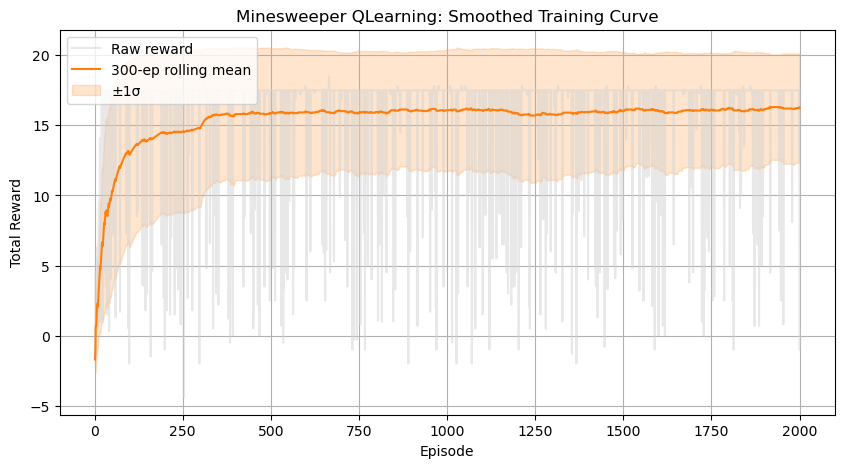

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# turn your list into a DataFrame
df = pd.DataFrame({
    'episode': range(1, len(episode_rewards)+1),
    'reward': episode_rewards
})

# compute rolling statistics
window = 300
df['roll_mean'] = df['reward'].rolling(window, min_periods=1).mean()
df['roll_std']  = df['reward'].rolling(window, min_periods=1).std().fillna(0)

# now plot
plt.figure(figsize=(10,5))
# raw rewards as faint background
plt.plot(df['episode'], df['reward'], color='lightgray', alpha=0.5, label='Raw reward')
# rolling mean
plt.plot(df['episode'], df['roll_mean'], color='C1', label=f'{window}-ep rolling mean')
# ±1σ shading
plt.fill_between(df['episode'],
                 df['roll_mean'] - df['roll_std'],
                 df['roll_mean'] + df['roll_std'],
                 color='C1', alpha=0.2, label='±1σ')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Minesweeper QLearning: Smoothed Training Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [45]:
# 1) Unpack reset() into state and info
state, info = env.reset()
print("Initial board:")
print_board(state)

# 2) Build initial legal list
legal = legal_indices(
    info['action_mask_click'],
    info['action_mask_flag'],
    env.size_x, env.size_y
)

# 3) Switch to greedy policy
agent.epsilon = 0.0

done = False
step = 0
tot_reward = 0.0

while not done and step < env.max_steps:
    # pass both state and legal into act()
    a_idx  = agent.act(state, legal)
    action = index_to_action(a_idx, env.size_x, env.size_y)
    print(f"Step {step}: action={action}")

    next_state, reward, done, info = env.step(action)
    print(f" Reward: {reward:.2f}")
    print_board(next_state)

    # recompute legal moves before the next decision
    legal = legal_indices(
        info['action_mask_click'],
        info['action_mask_flag'],
        env.size_x, env.size_y
    )

    state = next_state
    tot_reward += reward
    step += 1

if done:
    print(f"Episode finished in {step} steps.")
    print(f"Total reward: {tot_reward:.2f}")
else:
    print("Reached max steps without finishing.")


Initial board:
# # # # #
# # # # #
# # # # #
# # # # #
# # # # #

Step 0: action=(0, 0, 4)
 Reward: 1.00
# # # # 1
# # # # #
# # # # #
# # # # #
# # # # #

Step 1: action=(0, 1, 4)
 Reward: 1.00
# # # # 1
# # # # 2
# # # # #
# # # # #
# # # # #

Step 2: action=(0, 1, 3)
 Reward: 1.00
# # # # 1
# # # 4 2
# # # # #
# # # # #
# # # # #

Step 3: action=(0, 2, 3)
 Reward: 1.00
# # # # 1
# # # 4 2
# # # 2 #
# # # # #
# # # # #

Step 4: action=(1, 2, 4)
 Reward: 0.50
# # # # 1
# # # 4 2
# # # 2 F
# # # # #
# # # # #

Step 5: action=(1, 2, 2)
 Reward: 0.50
# # # # 1
# # # 4 2
# # F 2 F
# # # # #
# # # # #

Step 6: action=(0, 3, 4)
 Reward: 1.00
# # # # 1
# # # 4 2
# # F 2 F
# # # # 1
# # # # #

Step 7: action=(0, 4, 4)
 Reward: 1.00
# # # # 1
# # # 4 2
# # F 2 F
# # 2 2 1
# # 1 0 0

Step 8: action=(0, 1, 2)
 Reward: 1.00
# # # # 1
# # 3 4 2
# # F 2 F
# # 2 2 1
# # 1 0 0

Step 9: action=(0, 1, 1)
 Reward: 1.00
# # # # 1
# 2 3 4 2
# # F 2 F
# # 2 2 1
# # 1 0 0

Step 10: action=(1, 0, 3)
 Reward:

# DQN (These need to be run on the UniBern Cluster) to see an improvement trend

### Ran on my computer for 40min with the DualNetork Agent (OLD REWARD SYSTEM)

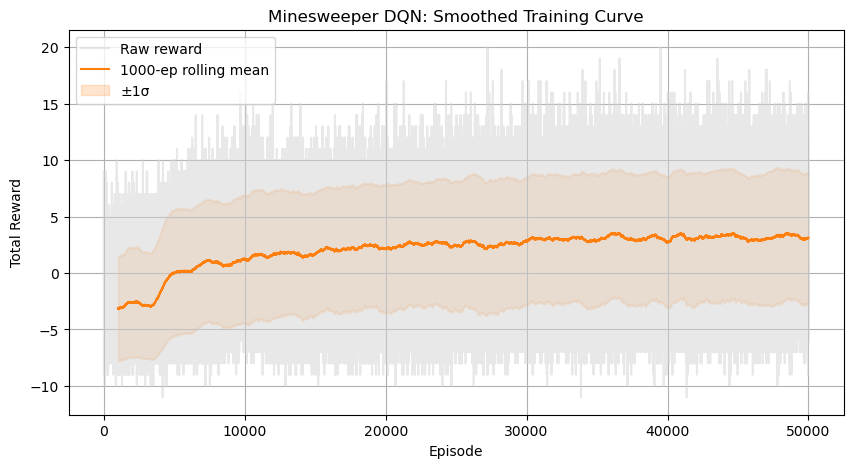<br>

### Lowering Statespace attempt:
- Only click action
- 5x5 grid

In [ ]:
from collections import deque
import numpy as np
from gym import Env
from gym.spaces import Discrete, Box

# Tile states
STATE_HIDDEN        = -1   # hidden/unopened
STATE_REVEALED_MINE = -2   # mine revealed when clicked

class MinesweeperEnv(Env):
    """
    Minesweeper environment (click-only) for Deep-RL.

    Observation: float32 image shape=(H, W, 2):
      channel 0 = hidden mask (1 if hidden, else 0)
      channel 1 = normalized revealed count (0–1)
    Action: Discrete(H * W), index = x * W + y, click only.
    """
    def __init__(
        self,
        size_x=10,
        size_y=10,
        mine_prob=0.1,
        deterministic=True,
        secure_first_click=False
    ):
        super().__init__()
        self.size_x = size_x
        self.size_y = size_y
        self.mine_prob = mine_prob
        self.secure_first_click = secure_first_click
        self.deterministic = deterministic
        self.max_steps = size_x * size_y

        # action: click only
        self.n_actions = size_x * size_y
        self.action_space = Discrete(self.n_actions)
        # observation: two channels, floats in [0,1]
        self.observation_space = Box(
            low=0.0,
            high=1.0,
            shape=(size_x, size_y, 2),
            dtype=np.float32
        )

        # RNG
        self.rng = None
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.rng = np.random.default_rng(seed)
        return [seed]

    def reset(self):
        """Reset game state and return initial observation."""
        self.first_click = True
        self.steps = 0
        self.clicked_count = 0
        self.mines = 0

        # state grid: -1 hidden, 0-8 revealed
        self.state = np.full((self.size_x, self.size_y), STATE_HIDDEN, dtype=np.int8)
        self.is_mine = np.zeros((self.size_x, self.size_y), dtype=bool)
        self.adjacent = np.zeros((self.size_x, self.size_y), dtype=np.int8)
        return self._get_obs()

    def step(self, action):
        """Perform click action and return (obs, reward, done, info)."""
        # decode click index
        x, y = divmod(action, self.size_y)
        reward = 0.0
        done = False

        # first click: place mines (protecting cell ± neighbors if requested)
        if self.first_click:
            self._place_mines(x, y)
            self.first_click = False

        # invalid click on already revealed cell
        if self.state[x, y] != STATE_HIDDEN:
            self.steps += 1
            return self._get_obs(), -1.0, False, {}

        # click on mine -> loss
        if self.is_mine[x, y]:
            self.state[x, y] = STATE_REVEALED_MINE
            reward = -1
            done = True
        else:
            # check blind guess (all neighbors hidden)
            neighbor_vals = []
            for dx in (-1, 0, 1):
                for dy in (-1, 0, 1):
                    nx, ny = x+dx, y+dy
                    if 0 <= nx < self.size_x and 0 <= ny < self.size_y:
                        neighbor_vals.append(self.state[nx, ny])
            is_guess = all(v == STATE_HIDDEN for v in neighbor_vals)
            # reveal region
            self._flood_fill(x, y)
            reward = -1.0 if is_guess else 1.0

        # check win: all safe revealed
        total_safe = self.size_x * self.size_y - self.mines
        if not done and self.clicked_count >= total_safe:
            reward += 5
            done = True

        # increment step and enforce limit
        self.steps += 1
        if not done and self.steps >= self.max_steps:
            done = True

        return self._get_obs(), reward, done, {}

    def _place_mines(self, safe_x, safe_y):
        """Initialize mines after first click, protecting tiles only if secure_first_click."""
        # fix the RNG seed for determinism
        self.rng = self.rng or np.random.default_rng(42 if self.deterministic else None)

        # only protect neighbors if secure_first_click is enabled
        protected = set()
        if self.secure_first_click:
            for dx in (-1, 0, 1):
                for dy in (-1, 0, 1):
                    nx, ny = safe_x + dx, safe_y + dy
                    if 0 <= nx < self.size_x and 0 <= ny < self.size_y:
                        protected.add((nx, ny))

        # place mines everywhere else
        self.mines = 0
        for i in range(self.size_x):
            for j in range(self.size_y):
                if (i, j) in protected:
                    continue
                if self.rng.random() < self.mine_prob:
                    self.is_mine[i, j] = True
                    self.mines += 1

        # compute adjacency counts
        for i in range(self.size_x):
            for j in range(self.size_y):
                if self.is_mine[i, j]:
                    continue
                count = 0
                for nx in range(max(0, i-1), min(self.size_x, i+2)):
                    for ny in range(max(0, j-1), min(self.size_y, j+2)):
                        if (nx, ny) != (i, j) and self.is_mine[nx, ny]:
                            count += 1
                self.adjacent[i, j] = count

    def _flood_fill(self, sx, sy):
        """Reveal zero-clusters and their borders via BFS."""
        queue = deque([(sx, sy)])
        while queue:
            i, j = queue.popleft()
            if self.state[i, j] != STATE_HIDDEN:
                continue
            self.state[i, j] = self.adjacent[i, j]
            self.clicked_count += 1
            if self.adjacent[i, j] == 0:
                for di in (-1, 0, 1):
                    for dj in (-1, 0, 1):
                        ni, nj = i+di, j+dj
                        if 0 <= ni < self.size_x and 0 <= nj < self.size_y:
                            queue.append((ni, nj))

    def _get_obs(self):
        """Return float32 image obs of shape (H, W, 2)."""
        hid = (self.state == STATE_HIDDEN).astype(np.float32)
        cnt = np.clip(self.state, 0, 8).astype(np.float32) / 8.0
        return np.stack([hid, cnt], axis=-1)

    def _reveal(self):
        """For debugging: return mine layout."""
        return self.is_mine.copy()


## Single-network CNN Minesweeper Agent

In [ ]:
import random
from collections import deque
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gym import Env
from gym.spaces import Discrete, Box

# Hyperparameters (matching the Keras example)
MEM_SIZE            = 50_000
MEM_SIZE_MIN        = 10_000
BATCH_SIZE          = 64
LEARN_RATE          = 0.01
LEARN_DECAY         = 0.99975
LEARN_MIN           = 0.001
DISCOUNT            = 0.9 
EPSILON_START       = 0.95
EPSILON_DECAY       = 0.98
EPSILON_MIN         = 0.01
CONV_UNITS          = 16 # 64 # 16
DENSE_UNITS         = 128 #512 # 128
UPDATE_TARGET_EVERY = 5

class QNetwork(nn.Module):
    """CNN: 4×Conv → Flatten → 2×Dense → Linear output"""
    def __init__(self, in_channels, height, width, conv_units, dense_units, n_actions):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,      conv_units, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv_units,       conv_units, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(conv_units,       conv_units, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(conv_units,       conv_units, kernel_size=3, padding=1)
        # infer conv output size
        dummy = torch.zeros(1, in_channels, height, width)
        x = F.relu(self.conv1(dummy))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        conv_size = x.view(1, -1).size(1)
        # dense layers
        self.fc1 = nn.Linear(conv_size, dense_units)
        self.fc2 = nn.Linear(dense_units, dense_units)
        self.out = nn.Linear(dense_units, n_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

class ReplayBuffer:
    """Replay buffer with warm-up."""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def append(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.stack(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.stack(next_states),
            np.array(dones, dtype=np.uint8)
        )

    def __len__(self):
        return len(self.buffer)

class DQNAgentTorch:
    """DQN agent for your click-only MinesweeperEnv."""
    def __init__(self, env: Env):
        self.env = env
        h, w, c = env.observation_space.shape
        n_actions = env.action_space.n
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # networks
        self.model = QNetwork(c, h, w, CONV_UNITS, DENSE_UNITS, n_actions).to(self.device)
        self.target_model = QNetwork(c, h, w, CONV_UNITS, DENSE_UNITS, n_actions).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        # optimizer
        self.lr = LEARN_RATE
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, eps=1e-4)

        # replay memory
        self.replay = ReplayBuffer(MEM_SIZE)
        self.target_update_counter = 0

        # exploration / discount
        self.epsilon = EPSILON_START
        self.discount = DISCOUNT

    def get_action(self, state: np.ndarray) -> int:
        # flatten hidden mask to choose only hidden cells
        flat = state[...,0].reshape(-1)
        valid = np.where(flat > 0.5)[0]
        # epsilon-greedy
        if random.random() < self.epsilon and len(valid) > 0:
            return int(random.choice(valid))
        # policy
        tensor = torch.from_numpy(state).permute(2,0,1).unsqueeze(0).float().to(self.device)
        with torch.no_grad():
            q = self.model(tensor).cpu().numpy().flatten()
        # invalidate non-hidden
        q[flat <= 0.5] = q.min() - 1
        return int(q.argmax())

    def update_replay(self, transition):
        self.replay.append(transition)

    def train_step(self, done: bool):
        if len(self.replay) < MEM_SIZE_MIN:
            return
        S, A, R, S2, D = self.replay.sample(BATCH_SIZE)
        s  = torch.from_numpy(S).permute(0,3,1,2).float().to(self.device)
        a  = torch.from_numpy(A).long().unsqueeze(1).to(self.device)
        r  = torch.from_numpy(R).unsqueeze(1).to(self.device)
        ns = torch.from_numpy(S2).permute(0,3,1,2).float().to(self.device)
        d  = torch.from_numpy(D).unsqueeze(1).float().to(self.device)

        q_vals = self.model(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_model(ns).max(1)[0].unsqueeze(1)
        q_target = torch.where(d==1, r, r + self.discount * q_next)

        loss = F.mse_loss(q_vals, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        if done:
            self.target_update_counter += 1
            if self.target_update_counter >= UPDATE_TARGET_EVERY:
                self.target_model.load_state_dict(self.model.state_dict())
                self.target_update_counter = 0
            # decay lr & epsilon
            self.lr = max(LEARN_MIN, self.lr * LEARN_DECAY)
            for pg in self.optimizer.param_groups:
                pg['lr'] = self.lr
            self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

    def train(self, episodes: int = 1000):
        for ep in range(episodes):
            state = self.env.reset()
            total = 0.0
            done = False
            while not done:
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                total += reward
                self.update_replay((state, action, reward, next_state, done))
                self.train_step(done)
                state = next_state
            print(f"Episode {ep+1} | Total Reward: {total:.2f} | Epsilon: {self.epsilon:.3f} | LR: {self.lr:.5f}")

    def evaluate(self, episodes: int = 10):
        rewards = []
        for _ in range(episodes):
            state = self.env.reset()
            total = 0.0
            done = False
            steps = 0
            while not done and steps < self.env.max_steps:
                tensor = torch.from_numpy(state).permute(2,0,1).unsqueeze(0).float().to(self.device)
                with torch.no_grad():
                    action = self.model(tensor).argmax(dim=1).item()
                state, reward, done, _ = self.env.step(action)
                total += reward
                steps += 1
            rewards.append(total)
        mean, std = np.mean(rewards), np.std(rewards)
        print(f"Eval over {episodes} eps: mean={mean:.2f} ± {std:.2f}")


In [ ]:
env = MinesweeperEnv(size_x=5, size_y=5, mine_prob=0.1, deterministic=True)
agent = DQNAgentTorch(env)
agent.train(episodes=5000)
agent.evaluate(episodes=10)

In [ ]:
import random
from collections import deque
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gym import Env
from gym.spaces import Discrete, Box

# Hyperparameters
MEM_SIZE            = 50_000
MEM_SIZE_MIN        = 10_000
BATCH_SIZE          = 64
LEARN_RATE          = 3e-4
LEARN_DECAY         = 0.99975
LEARN_MIN           = 1e-4
DISCOUNT            = 0.9
EPSILON_START       = 0.95
EPSILON_DECAY       = 0.98
EPSILON_MIN         = 0.01
CONV_UNITS          = 16
DENSE_UNITS         = 128
UPDATE_TARGET_EVERY = 5
ALPHA_PER           = 0.6    # prioritization exponent
BETA_PER_START      = 0.4    # initial importance-sampling exponent
BETA_PER_INC        = 1e-4  # beta increment per learning step

class PrioritizedReplayBuffer:
    """Prioritized Experience Replay buffer."""
    def __init__(self, capacity, alpha=ALPHA_PER):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = []
        self.pos = 0
    
    def append(self, transition, error=None):
        # transition: (state, action, reward, next_state, done)
        if error is None:
            priority = max(self.priorities, default=1.0)
        else:
            priority = (abs(error) + 1e-6) ** self.alpha
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
            self.priorities.append(priority)
        else:
            self.buffer[self.pos] = transition
            self.priorities[self.pos] = priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == 0:
            return [], [], [], [], [], [], []
        # compute probabilities
        ps = np.array(self.priorities, dtype=np.float32)
        probs = ps / ps.sum()
        # sample indices
        idxs = np.random.choice(len(self.buffer), batch_size, p=probs)
        # importance-sampling weights
        beta = min(1.0, beta)
        weights = (len(self.buffer) * probs[idxs]) ** (-beta)
        weights /= weights.max()
        # fetch samples
        batch = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.stack(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.stack(next_states),
            np.array(dones, dtype=np.uint8),
            idxs,
            weights
        )

    def update_priorities(self, idxs, errors):
        for i, err in zip(idxs, errors):
            self.priorities[i] = (abs(err) + 1e-6) ** self.alpha

    def __len__(self):
        return len(self.buffer)

class DuelingQNetwork(nn.Module):
    """Dueling DQN: separate value and advantage streams."""
    def __init__(self, in_channels, height, width, conv_units, dense_units, n_actions):
        super().__init__()
        # shared conv layers
        self.conv1 = nn.Conv2d(in_channels,      conv_units, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv_units,       conv_units, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(conv_units,       conv_units, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(conv_units,       conv_units, kernel_size=3, padding=1)
        # infer conv output size
        dummy = torch.zeros(1, in_channels, height, width)
        x = F.relu(self.conv1(dummy))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        conv_size = x.view(1, -1).size(1)
        # value stream
        self.value_fc = nn.Linear(conv_size, dense_units)
        self.value_out = nn.Linear(dense_units, 1)
        # advantage stream
        self.adv_fc = nn.Linear(conv_size, dense_units)
        self.adv_out = nn.Linear(dense_units, n_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        # value
        v = F.relu(self.value_fc(x))
        v = self.value_out(v)
        # advantage
        a = F.relu(self.adv_fc(x))
        a = self.adv_out(a)
        # combine
        q = v + (a - a.mean(dim=1, keepdim=True))
        return q

class DQNAgentTorch:
    """DQN agent with Double-DQN, Dueling, and PER."""
    def __init__(self, env: Env):
        self.env = env
        h, w, c = env.observation_space.shape
        n_actions = env.action_space.n
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # networks
        self.model = DuelingQNetwork(c, h, w, CONV_UNITS, DENSE_UNITS, n_actions).to(self.device)
        self.target_model = DuelingQNetwork(c, h, w, CONV_UNITS, DENSE_UNITS, n_actions).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        # optimizer
        self.lr = LEARN_RATE
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        # PER buffer
        self.replay = PrioritizedReplayBuffer(MEM_SIZE)
        self.beta = BETA_PER_START
        self.beta_inc = BETA_PER_INC
        self.target_update_counter = 0

        # exploration and discount
        self.epsilon = EPSILON_START
        self.discount = DISCOUNT

    def get_action(self, state: np.ndarray) -> int:
        flat = state[...,0].reshape(-1)
        valid = np.where(flat > 0.5)[0]
        if random.random() < self.epsilon and valid.size > 0:
            return int(random.choice(valid))
        tensor = torch.from_numpy(state).permute(2,0,1).unsqueeze(0).float().to(self.device)
        with torch.no_grad():
            q = self.model(tensor).cpu().numpy().flatten()
        q[flat <= 0.5] = q.min() - 1
        return int(q.argmax())

    def train_step(self, done: bool):
        if len(self.replay) < MEM_SIZE_MIN:
            return
        S, A, R, S2, D, idxs, weights = self.replay.sample(BATCH_SIZE, beta=self.beta)
        # increase beta toward 1
        self.beta = min(1.0, self.beta + self.beta_inc)

        s   = torch.from_numpy(S).permute(0,3,1,2).float().to(self.device)
        a   = torch.from_numpy(A).long().unsqueeze(1).to(self.device)
        r   = torch.from_numpy(R).unsqueeze(1).to(self.device)
        ns  = torch.from_numpy(S2).permute(0,3,1,2).float().to(self.device)
        d   = torch.from_numpy(D).unsqueeze(1).float().to(self.device)
        w   = torch.from_numpy(weights).unsqueeze(1).float().to(self.device)

        # current Q(s,a)
        q_vals = self.model(s).gather(1, a)

        # Double-DQN target
        with torch.no_grad():
            next_actions = self.model(ns).argmax(dim=1, keepdim=True)
            q_next = self.target_model(ns).gather(1, next_actions)

        # compute target
        q_target = torch.where(d == 1, r, r + self.discount * q_next)

        # compute weighted loss
        loss = (w * F.mse_loss(q_vals, q_target, reduction='none')).mean()
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        # update priorities
        td_errors = (q_target - q_vals).detach().cpu().numpy().flatten()
        self.replay.update_priorities(idxs, td_errors)

        if done:
            self.target_update_counter += 1
            if self.target_update_counter >= UPDATE_TARGET_EVERY:
                self.target_model.load_state_dict(self.model.state_dict())
                self.target_update_counter = 0
            # decay lr & epsilon
            self.lr = max(LEARN_MIN, self.lr * LEARN_DECAY)
            for pg in self.optimizer.param_groups:
                pg['lr'] = self.lr
            self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

    def train(self, episodes: int = 1000):
        for ep in range(episodes):
            state = self.env.reset()
            total, done = 0.0, False
            while not done:
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                total += reward
                # compute initial error for new sample
                self.replay.append((state, action, reward, next_state, done))
                state = next_state
                self.train_step(done)
            print(f"Episode {ep+1} | Total Reward: {total:.2f} | Epsilon: {self.epsilon:.3f} | LR: {self.lr:.5f}")

    def evaluate(self, episodes: int = 10):
        """
        Evaluate the trained agent over a number of episodes using greedy policy.
        Returns:
            mean_reward (float), std_reward (float), win_rate (float)
        """
        rewards = []
        wins = 0

        for _ in range(episodes):
            state = self.env.reset()
            total = 0.0
            done = False
            steps = 0

            while not done and steps < self.env.max_steps:
                # select greedy action
                tensor = torch.from_numpy(state).permute(2,0,1).unsqueeze(0).float().to(self.device)
                with torch.no_grad():
                    action = self.model(tensor).argmax(dim=1).item()
                state, reward, done, _ = self.env.step(action)
                total += reward
                steps += 1

            rewards.append(total)
            # count as win if we finish with non-negative total (no early mine loss)
            if total >= 0:
                wins += 1

        mean_reward = np.mean(rewards)
        std_reward  = np.std(rewards)
        win_rate    = wins / episodes
        
        return mean_reward, std_reward, win_rate


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Collect metrics during training ---
env = MinesweeperEnv(size_x=5, size_y=5, mine_prob=0.2, deterministic=True, secure_first_click=False)
agent = DQNAgentTorch(env)

episodes = 50000
train_rewards = []
eval_rewards = []

for ep in range(1, episodes+1):
    state = env.reset()
    total_r = 0.0
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.replay.append((state, action, reward, next_state, done))
        agent.train_step(done)
        state = next_state
        total_r += reward
    train_rewards.append(total_r)
    
    # Periodic evaluation every 50 episodes
    if ep % 50 == 0:
        r, std = agent.evaluate(episodes=20)  # modify evaluate to return mean,std
        eval_rewards.append((ep, r))
        print(f"Episode {ep} | Eval Reward: {r:.2f} ± {std:.2f}")

# Create DataFrame
df = pd.DataFrame({
    'episode': list(range(1, episodes+1)),
    'train_reward': train_rewards
})

# save as CSV
df.to_csv('minesweeper_dqn_rewards.csv', index=False)

window = 300
df['roll_mean'] = df['train_reward'].rolling(window).mean()
df['roll_std']  = df['train_reward'].rolling(window).std()

# plot
plt.figure(figsize=(10,5))
plt.plot(df['episode'], df['train_reward'], color='lightgray', alpha=0.5, label='Raw reward')
plt.plot(df['episode'], df['roll_mean'],    color='C1',      label=f'{window}-ep rolling mean')
plt.fill_between(df['episode'],
                 df['roll_mean'] - df['roll_std'],
                 df['roll_mean'] + df['roll_std'],
                 color='C1', alpha=0.2, label=f'±1σ')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Minesweeper DQN: Smoothed Training Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

#save the model
torch.save(agent.model.state_dict(), 'minesweeper_dqn_model.pth')
#save the plot
plt.savefig('minesweeper_dqn_training_curve.png')

# Next Steps
* integrate MCTS in the evaluation after training the model
* if feasable integrate it like the AlphaGo Zero 

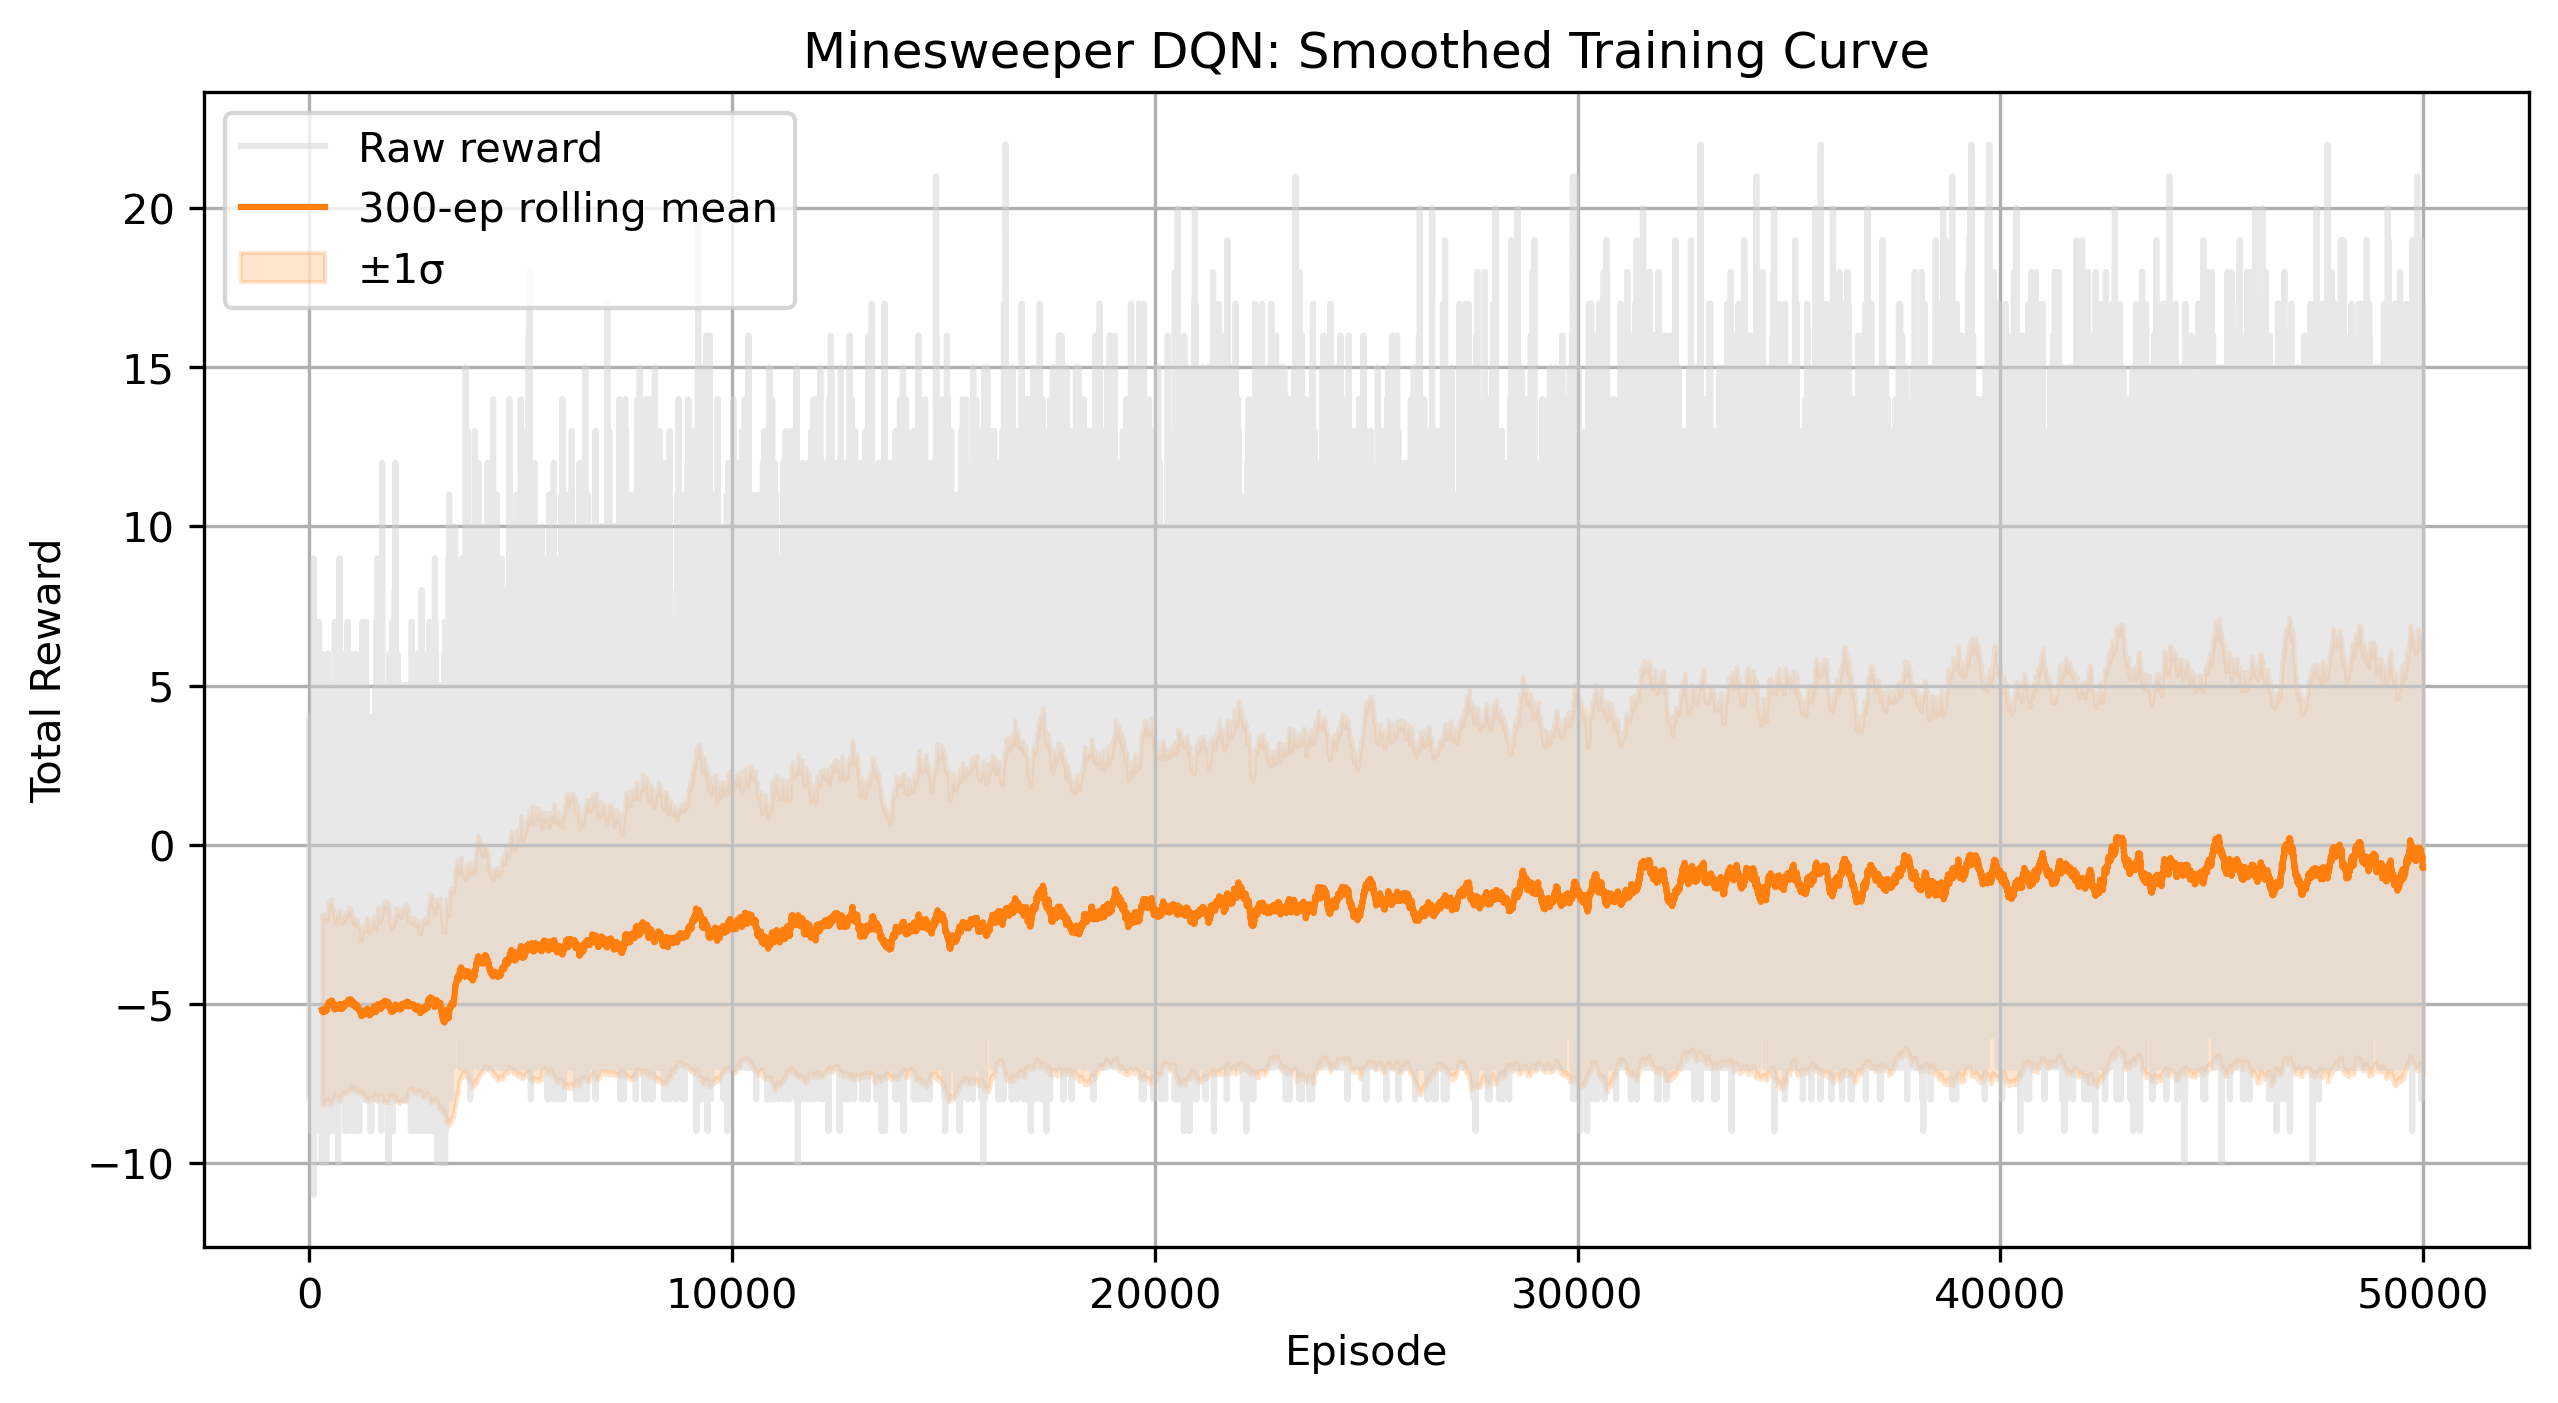

In [36]:
# load the CSV file (ensure the file is in the current working directory)
df = pd.read_csv('MS_RL/minesweeper_dqn_rewards.csv')

# compute rolling statistics
window = 300
df['roll_mean'] = df['train_reward'].rolling(window).mean()
df['roll_std'] = df['train_reward'].rolling(window).std()

# plot the smoothed curve
plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['episode'], df['train_reward'], color='lightgray', alpha=0.5, label='Raw reward')
plt.plot(df['episode'], df['roll_mean'], color='C1', label=f'{window}-ep rolling mean')
plt.fill_between(df['episode'],
                 df['roll_mean'] - df['roll_std'],
                 df['roll_mean'] + df['roll_std'],
                 color='C1', alpha=0.2, label='±1σ')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Minesweeper DQN: Smoothed Training Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

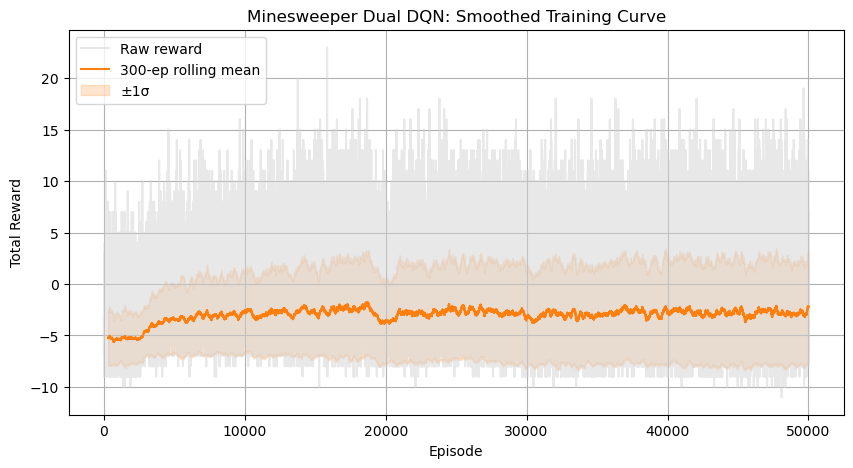

In [33]:
# load the CSV file (ensure the file is in the current working directory)
df = pd.read_csv('minesweeper_dqn_rewards.csv')

# compute rolling statistics
window = 300
df['roll_mean'] = df['train_reward'].rolling(window).mean()
df['roll_std'] = df['train_reward'].rolling(window).std()

# plot the smoothed curve
plt.figure(figsize=(10,5))
plt.plot(df['episode'], df['train_reward'], color='lightgray', alpha=0.5, label='Raw reward')
plt.plot(df['episode'], df['roll_mean'], color='C1', label=f'{window}-ep rolling mean')
plt.fill_between(df['episode'],
                 df['roll_mean'] - df['roll_std'],
                 df['roll_mean'] + df['roll_std'],
                 color='C1', alpha=0.2, label='±1σ')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Minesweeper Dual DQN: Smoothed Training Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# DQN env with QLearning

In [81]:
import torch
from collections import deque
from gym import Env
import numpy as np
from gym.spaces import Discrete, Box

# Tile states
STATE_HIDDEN        = -1   # hidden/unopened
STATE_REVEALED_MINE = -2   # mine revealed when clicked

class MinesweeperEnv(Env):
    """
    Minesweeper environment (click-only) for Deep-RL, but fully torch-based.
    Observation: float32 image shape=(H, W, 2):
      channel 0 = hidden mask (1 if hidden, else 0)
      channel 1 = normalized revealed count (0–1)
    Action: Discrete(H * W), index = x * W + y, click only.
    """
    def __init__(
        self,
        size_x=10,
        size_y=10,
        mine_prob=0.1,
        deterministic=True,
        secure_first_click=False,
        device=None
    ):
        super().__init__()
        self.device = torch.device(
            device or (
                "cuda" if torch.cuda.is_available() else (
                    "mps" if (hasattr(torch, "mps") and torch.mps.is_available()) else "cpu"
                )
            )
        )
        self.size_x = size_x
        self.size_y = size_y
        self.mine_prob = mine_prob
        self.secure_first_click = secure_first_click
        self.deterministic = deterministic
        self.max_steps = size_x * size_y
        self.done = False

        # action & observation spaces (unchanged)
        self.n_actions = size_x * size_y
        self.action_space = Discrete(self.n_actions)
        self.observation_space = Box(
            low=0.0,
            high=1.0,
            shape=(size_x, size_y, 2),
            dtype=np.float32      # ← use a NumPy dtype
        )

        # RNG placeholder
        self.rng = None
        self.reset()

    def reset(self):
        self.first_click = True
        self.done = False
        self.steps = 0
        self.clicked_count = 0
        self.mines = 0

        # all state tensors on device
        self.state   = torch.full((self.size_x, self.size_y),
                                  fill_value=STATE_HIDDEN,
                                  dtype=torch.int8,
                                  device=self.device)
        self.is_mine = torch.zeros((self.size_x, self.size_y),
                                   dtype=torch.bool,
                                   device=self.device)
        self.adjacent = torch.zeros((self.size_x, self.size_y),
                                    dtype=torch.int8,
                                    device=self.device)
        return self._get_obs()

    def step(self, action):
        self.steps += 1
        x, y = divmod(int(action), self.size_y)
        reward = 0.0

        # first click: place mines
        if self.first_click:
            self._place_mines(x, y)
            self.first_click = False

        # invalid click
        if self.state[x, y] != STATE_HIDDEN:
            return self._get_obs(), -1.0, False, {}

        # clicked on mine: lose
        if self.is_mine[x, y]:
            self.state[x, y] = STATE_REVEALED_MINE
            self.done = True
            return self._get_obs(), -1.0, self.done, {}

        # else reveal region
        # check blind guess: all neighbors hidden?
        neighbor_vals = []
        for dx in (-1,0,1):
            for dy in (-1,0,1):
                nx, ny = x+dx, y+dy
                if 0 <= nx < self.size_x and 0 <= ny < self.size_y:
                    neighbor_vals.append(self.state[nx, ny] == STATE_HIDDEN)
        is_guess = all(v.item() for v in neighbor_vals)

        self._flood_fill(x, y)
        reward = -1.0 if is_guess else 1.0

        # check win
        total_safe = self.size_x*self.size_y - int(self.is_mine.sum().item())
        if self.clicked_count >= total_safe:
            reward += 1.0
            self.done = True

        # step count
        if not self.done and self.steps >= self.max_steps:
            self.done = True

        return self._get_obs(), reward, self.done, {}

    def _place_mines(self, safe_x, safe_y):
        self.mine_rng = torch.Generator(device=self.device)
        if self.deterministic:
            self.mine_rng.manual_seed(42)  # or any fixed value
        else:
            self.mine_rng.seed()  # random seed per env
        rand = torch.rand((self.size_x, self.size_y),
                  generator=self.mine_rng,
                  device=self.device)
        mask = rand < self.mine_prob

        # optionally protect neighbors
        if self.secure_first_click:
            for dx in (-1,0,1):
                for dy in (-1,0,1):
                    nx, ny = safe_x+dx, safe_y+dy
                    if 0 <= nx < self.size_x and 0 <= ny < self.size_y:
                        mask[nx, ny] = False

        self.is_mine.copy_(mask)
        self.mines = int(mask.sum().item())

        # compute adjacency by rolling
        adj = torch.zeros_like(self.adjacent)
        for dx in (-1,0,1):
            for dy in (-1,0,1):
                if dx==0 and dy==0: continue
                adj += mask.roll(shifts=(dx,dy), dims=(0,1)).to(torch.int8)
        self.adjacent.copy_(adj)

    def _flood_fill(self, sx, sy):
        q = [(sx, sy)]
        while q:
            i, j = q.pop()
            if self.state[i, j] != STATE_HIDDEN:
                continue
            cnt = int(self.adjacent[i, j].item())
            self.state[i, j] = cnt
            self.clicked_count += 1
            self.steps += 1
            if cnt == 0:
                for dx in (-1,0,1):
                    for dy in (-1,0,1):
                        ni, nj = i+dx, j+dy
                        if 0 <= ni < self.size_x and 0 <= nj < self.size_y:
                            q.append((ni, nj))

    def _get_obs(self):
        hid = (self.state == STATE_HIDDEN).to(torch.float32)
        cnt = torch.clamp(self.state, 0, 8).to(torch.float32) / 8.0
        return torch.stack([hid, cnt], dim=-1)

    def _reveal(self):
        return self.is_mine.clone()


In [82]:
class QLearningAgent:
    def __init__(self, n_actions, alpha, gamma, epsilon):
        self.n_actions = n_actions
        self.lr = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(self.n_actions))

    def state_key(self, state):
        if isinstance(state, torch.Tensor):
            state = state.cpu().numpy()
        return tuple(state.flatten().tolist())

    def act(self, state):
        key = self.state_key(state)
        if random.random() < self.epsilon:
            return random.randrange(self.n_actions)
        qvals = self.Q[key]
        best = np.flatnonzero(qvals == qvals.max())
        return random.choice(best)

    def update(self, state, action, reward, next_state):
        k = self.state_key(state)
        k2 = self.state_key(next_state)
        target = reward + self.gamma * np.max(self.Q[k2])
        self.Q[k][action] += self.lr * (target - self.Q[k][action])

    def reset(self):
        self.Q.clear()

Episode 1 | Total Reward: -6.00 | Epsilon: 0.196
Episode 2 | Total Reward: -2.00 | Epsilon: 0.192
Episode 3 | Total Reward: -1.00 | Epsilon: 0.188
Episode 4 | Total Reward: -1.00 | Epsilon: 0.184
Episode 5 | Total Reward: -4.00 | Epsilon: 0.181
Episode 6 | Total Reward: -5.00 | Epsilon: 0.177
Episode 7 | Total Reward: -3.00 | Epsilon: 0.174
Episode 8 | Total Reward: -2.00 | Epsilon: 0.170
Episode 9 | Total Reward: -7.00 | Epsilon: 0.167
Episode 10 | Total Reward: -7.00 | Epsilon: 0.163
Episode 11 | Total Reward: -3.00 | Epsilon: 0.160
Episode 12 | Total Reward: -1.00 | Epsilon: 0.157
Episode 13 | Total Reward: -2.00 | Epsilon: 0.154
Episode 14 | Total Reward: -2.00 | Epsilon: 0.151
Episode 15 | Total Reward: -1.00 | Epsilon: 0.148
Episode 16 | Total Reward: -4.00 | Epsilon: 0.145
Episode 17 | Total Reward: -1.00 | Epsilon: 0.142
Episode 18 | Total Reward: -2.00 | Epsilon: 0.139
Episode 19 | Total Reward: -8.00 | Epsilon: 0.136
Episode 20 | Total Reward: -6.00 | Epsilon: 0.134
Episode 2

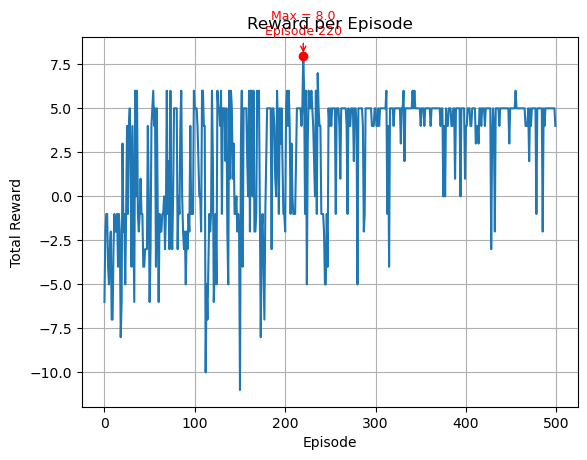

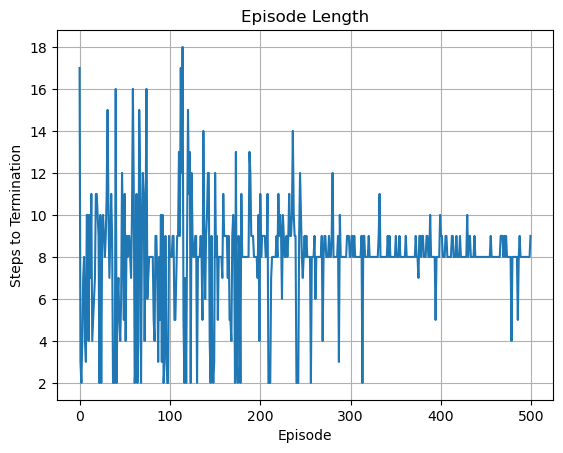

In [89]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random


# --- hyperparams ---
N_EPISODES = 500
ALPHA      = 0.01
GAMMA      = 0.9
EPSILON    = 0.2           # start lower (less random)
MIN_EPSILON = 0.05         # still allow minimal exploration
EPSILON_DECAY = 0.98       # faster decay

# --- env ---
env = MinesweeperEnv(size_x=5, size_y=5, mine_prob=0.2, deterministic=True, secure_first_click=False)
size_x, size_y = env.size_x, env.size_y
n_actions = size_x * size_y

agent = QLearningAgent(n_actions, alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON)

# --- metrics ---
episode_rewards = []
episode_lengths = []
mine_board = []
best_reward = float('-inf')
best_episode = []
best_actions = []



for ep in range(N_EPISODES):
    state = env.reset()
    total_r = 0.0
    done = False
    t = 0

    episode_states = [state.cpu().clone()]
    episode_actions = []

    while not done:
        a_idx = agent.act(state)
        next_state, reward, done, _ = env.step(a_idx)
        agent.update(state, a_idx, reward, next_state)

        state = next_state
        total_r += reward
        t += 1

        episode_states.append(state.cpu().clone())
        episode_actions.append(a_idx)
    
    mine_board.append(env._reveal().cpu().numpy())
    
    if total_r > best_reward:
        best_reward = total_r
        best_episode = episode_states
        best_actions = episode_actions

    episode_rewards.append(total_r)
    episode_lengths.append(t + 1)
    base = mine_board[0]
    agent.epsilon = max(MIN_EPSILON, agent.epsilon * EPSILON_DECAY) 
    if ep % 1 == 0:
        print(f"Episode {ep+1} | Total Reward: {total_r:.2f} | Epsilon: {agent.epsilon:.3f}")

# --- reward plot ---
idx_max = np.argmax(episode_rewards)
max_val = episode_rewards[idx_max]

fig, ax = plt.subplots()
ax.plot(episode_rewards, label="Reward")
ax.scatter(idx_max, max_val, color="red", zorder=5)
ax.annotate(f"Max = {max_val:.1f}\nEpisode {idx_max}",
            xy=(idx_max, max_val),
            xytext=(0, 15),
            textcoords="offset points",
            ha="center",
            color="red",
            fontsize=9,
            arrowprops=dict(arrowstyle="->", color="red"))

ax.set_xlabel("Episode")
ax.set_ylabel("Total Reward")
ax.set_title("Reward per Episode")
ax.grid(True)

ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, max_val + (ymax - ymin) * 0.05)

# --- episode length plot ---
fig, ax = plt.subplots()
ax.plot(episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Steps to Termination")
ax.set_title("Episode Length")
ax.grid(True)

plt.show()


In [90]:
mine_board = np.array(mine_board)

def all_elements_equal(arr):
    first = arr[0]
    for i in range(1, len(arr)):
        if not np.array_equal(arr[i], first):
            print(f"Difference found at index {i}:")
            print("First board:\n", first)
            print(f"Different board at step {i}:\n", arr[i])
            return False
    return True

all_equal = all_elements_equal(mine_board)

if all_equal:
    print("All elements in the mine board are equal.")
else:
    print("Not all elements in the mine board are equal.")

All elements in the mine board are equal.


In [91]:
mine_board[0]

array([[False, False, False, False, False],
       [False, False,  True, False,  True],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False,  True]])

In [93]:
def print_board(obs):
    """Pretty-print the visible Minesweeper board from observation"""
    charmap = {-1: '#', -2: '💣'}
    obs_np = obs.cpu().numpy() if isinstance(obs, torch.Tensor) else obs
    mask = obs_np[:, :, 0]      # 1 if hidden
    values = obs_np[:, :, 1]    # normalized revealed values (0–1)

    board = []
    for i in range(obs_np.shape[0]):
        row = []
        for j in range(obs_np.shape[1]):
            if mask[i, j] > 0.5:
                row.append('#')  # hidden
            else:
                val = int(values[i, j] * 8 + 0.5)
                row.append(str(val))
        board.append(row)

    for row in board:
        print(' '.join(row))
    print()

# --- Test greedy agent ---
agent.epsilon = 0.0  # no exploration

state = env.reset()
print("Initial board:")
print_board(state)

done = False
step = 0
tot_reward = 0.0

while not done and step < env.max_steps:
    a_idx = agent.act(state)
    x, y = divmod(a_idx, env.size_y)
    print(f"Step {step}: action=({x}, {y})")

    next_state, reward, done, _ = env.step(a_idx)
    print(f" Reward: {reward:.2f}")
    print_board(next_state)

    state = next_state
    tot_reward += reward
    step += 1

if done:
    print(f"Episode finished in {step} steps.")
    print(f"Total reward: {tot_reward:.2f}")
else:
    print("Reached max steps without finishing.")

print("\n=== BEST EPISODE ===")
print(f"Reward: {best_reward:.2f} | Steps: {len(best_actions)}")

for step, (state, action) in enumerate(zip(best_episode[:-1], best_actions)):
    x, y = divmod(action, env.size_y)
    print(f"\nStep {step} → Action: ({x}, {y})")
    print_board(state)
print("\nFinal State:")
print_board(best_episode[-1])



Initial board:
# # # # #
# # # # #
# # # # #
# # # # #
# # # # #

Step 0: action=(3, 2)
 Reward: -1.00
# # # # #
# # # # #
1 1 1 2 #
1 0 0 1 #
1 0 0 1 #

Step 1: action=(1, 0)
 Reward: 1.00
# # # # #
1 # # # #
1 1 1 2 #
1 0 0 1 #
1 0 0 1 #

Step 2: action=(2, 4)
 Reward: 1.00
# # # # #
1 # # # #
1 1 1 2 1
1 0 0 1 #
1 0 0 1 #

Step 3: action=(1, 3)
 Reward: 1.00
# # # # #
1 # # 2 #
1 1 1 2 1
1 0 0 1 #
1 0 0 1 #

Step 4: action=(0, 2)
 Reward: 1.00
# # 1 # #
1 # # 2 #
1 1 1 2 1
1 0 0 1 #
1 0 0 1 #

Step 5: action=(0, 4)
 Reward: 1.00
# # 1 # 2
1 # # 2 #
1 1 1 2 1
1 0 0 1 #
1 0 0 1 #

Step 6: action=(0, 0)
 Reward: 1.00
2 # 1 # 2
1 # # 2 #
1 1 1 2 1
1 0 0 1 #
1 0 0 1 #

Episode finished in 7 steps.
Total reward: 5.00

=== BEST EPISODE ===
Reward: 8.00 | Steps: 10

Step 0 → Action: (2, 2)
# # # # #
# # # # #
# # # # #
# # # # #
# # # # #


Step 1 → Action: (2, 1)
# # # # #
# # # # #
# # 1 # #
# # # # #
# # # # #


Step 2 → Action: (2, 0)
# # # # #
# # # # #
# 1 1 # #
# # # # #
# # # # #


